# **Install PyTorch**





In [1]:
!pip install -U torch torchvision tqdm lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 109.5 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.4.0
    Uninstalling lxml-5.4.0:
      Successfully uninstalled lxml-5.4.0


In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 58.5 MB/s eta 0:00:00


# **ID Class Imbalance (Shadow vs. Object)**

This script gives me a quick sanity check of label balance in my sonar dataset. It mounts Google Drive, walks through all VOC-style XML files under `Annotations/`, counts how many instances are labeled **object** and **shadow**, and prints totals plus percentages.

---

## What it expects

- **Environment:** Google Colab (uses `drive.mount('/content/drive')`).
- **Layout:** Pascal VOC structure at  
  `/content/drive/MyDrive/sonar-object-detection/data/line2voc/Annotations/*.xml`
- **Labels:** Each `<object>` has a `<name>` tag that should be either `object` or `shadow`.  
  I lowercase the tag before checking.

---

## What it does (step by step)

1. **Mount Drive**  
   Connects Colab to my Google Drive so the dataset is accessible under `/content/drive`.

2. **Set paths and counters**  
   Points at the `Annotations` folder and initializes counters for both classes.

3. **Parse every XML**  
   - Parse with `xml.etree.ElementTree`.
   - Iterate over all `<object>` entries in each file.
   - Read the `name`, normalize to lowercase, and bump the **object** or **shadow** counter.  
     Any other label is skipped.

4. **Print a summary**  
   Reports:
   - Count for **object**
   - Count for **shadow**
   - **Total** instances
   - Percent share of each class

---

## Why I run this

- **Data balance check:** If one class dominates, I might adjust sampling, weighting, or augmentation.
- **Label hygiene:** Catches typos or unexpected labels early (e.g., `Object`, `Shadow`).
- **Quick QA:** Confirms that annotations are present in the folder I expect.

---

## Edge cases & notes

- If there are **no annotations** (`total = 0`), the percentage lines would divide by zero.  
  I usually run this once I know the folder has XMLs.
- This counts **instances**, not images. An image with 3 boxes contributes 3 to the total.
- It doesn’t validate coordinates or check for matching image files—this is a label tally only.
- Unknown labels are silently skipped; if I expect only two classes, any skip hints at a labeling issue.
- If the dataset is split (train/val/test), this script reads **all** XMLs in `Annotations/`.  
  For per-split counts, I’d filter by IDs in `ImageSets/Main/{split}.txt`.

---

## Useful extensions (if needed later)

- **Per-split counts** using the image set text files.
- **More classes** by adding additional label checks.
- **Robustness** with `try/except` around XML parsing and a counter for broken files.
- **Histogram by image** (instances per image) to spot outliers.

---

In [ ]:
# STEP 1: Mount Google Drive
# Enables access to sonar dataset stored in Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import libraries and set the paths
import os
from pathlib import Path
from xml.etree import ElementTree as ET

# Define the annotation directory
ANNOTATION_DIR = Path("/content/drive/MyDrive/sonar-object-detection/data/line2voc/Annotations")

# Set up counters for both object classes
object_count = 0
shadow_count = 0

# STEP 3: Iterate through annotations and count labels
# Parse each XML annotation file and count number of "object" and "shadow" instances

for xml_file in ANNOTATION_DIR.glob("*.xml"):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Each file may contain multiple objects -> loop through all of them
    for obj in root.findall("object"):
        label = obj.find("name").text.strip().lower()  # This normalize label format

        if label == "object":
            object_count += 1
        elif label == "shadow":
            shadow_count += 1
        else:
            continue  # Skip unlabelled classes

# STEP 4: Print a quick summary
total = object_count + shadow_count

print("=== Annotation Summary ===")
print(f"Number of 'object' annotations : {object_count}")
print(f"Number of 'shadow' annotations : {shadow_count}")
print(f"Total annotations              : {total}")
print(f"Percentage 'object'            : {100 * object_count / total:.2f}%")
print(f"Percentage 'shadow'            : {100 * shadow_count / total:.2f}%")

Mounted at /content/drive
=== Annotation Summary ===
Number of 'object' annotations : 12842
Number of 'shadow' annotations : 15079
Total annotations              : 27921
Percentage 'object'            : 45.99%
Percentage 'shadow'            : 54.01%


# **Rebuilding VOC Split Files (train/val/test) with Sanity Checks**

This utility rebuilds `train.txt` and `val.txt` from the set of **existing images** in `JPEGImages/`, while **leaving `test.txt` untouched**. I back up the original split files, collect all valid `.jpg` image IDs, remove any that belong to the test set, shuffle with a fixed seed, and write a fresh 85/15 split.

---

## Assumptions and Layout

- **Environment:** Google Colab (uses `drive.mount('/content/drive')`).
- **Dataset root:**  
  `/content/drive/MyDrive/sonar-object-detection/data/line2voc`
- **VOC structure used:**
  - `JPEGImages/*.jpg` — image files
  - `ImageSets/Main/{train,val,test}.txt` — split lists (one ID per line, no extension)

> Note: This script verifies the presence of **images** only. If I also want to verify that each ID has a matching XML annotation, I run my cleaning script separately.

---

## What the script does

1. **Mount Drive**  
   So paths under `/content/drive` are available in Colab.

2. **Back up the current splits**  
   Copies `train.txt`, `val.txt`, and `test.txt` (if they exist) to `train_original.txt`, `val_original.txt`, and `test_original.txt` in the same folder.

3. **Lock the test set**  
   Reads the IDs from `test.txt` and keeps them as is. If `test.txt` is missing, the script proceeds with an empty test set and logs that.

4. **Collect valid image IDs**  
   Scans `JPEGImages/` for `.jpg` files and takes the stems (filenames without extension) as valid IDs.

5. **Build train/val from the remaining pool**  
   Removes test IDs from the pool, shuffles with `random.seed(42)` for reproducibility, and splits **85% train / 15% val**.

6. **Write new lists**  
   Saves the rebuilt `train.txt` and `val.txt`, and leaves `test.txt` unchanged. Finally prints a count and ratio summary for all three splits.

---

## Outputs

- `ImageSets/Main/train_original.txt` (backup, if source existed)  
- `ImageSets/Main/val_original.txt` (backup, if source existed)  
- `ImageSets/Main/test_original.txt` (backup, if source existed)  
- `ImageSets/Main/train.txt` (rebuilt)  
- `ImageSets/Main/val.txt` (rebuilt)  
- `ImageSets/Main/test.txt` (unchanged)  
- Console summary with counts and percentages

---

## Why I do it this way

- **Consistency:** Ensures train/val IDs correspond to actual images on disk.
- **Reproducibility:** Fixed seed gives me the same train/val split across runs.
- **Test integrity:** Keeps the held-out test set completely untouched.

---

## Limitations and notes

- **Images only:** This does not check for `Annotations/*.xml` or validate bounding boxes. I run a separate pass if I need to guarantee `.xml` is present for every ID.
- **Non-stratified:** The split is random, not stratified by class. If label balance matters, I’d stratify using the annotations.
- **File extensions:** Only `.jpg` files are considered; if I have `.png`/`.JPG`, I’d extend the glob accordingly.
- **Trailing newline:** The script writes a newline at the end of each split file; this is intentional to match common VOC conventions.

---

In [ ]:
# SPLIT FILE INTEGRITY VERIFICATION AND REBUILD: VOC FORMAT
# Purpose is to rebuild train;val;test split files with valid image references

from google.colab import drive
from pathlib import Path
import shutil
import random

# STEP 0: Mount Google Drive and set the paths
drive.mount('/content/drive')

# Define dataset and folder structure
DATASET_DIR = Path("/content/drive/MyDrive/sonar-object-detection/data/line2voc")
image_dir = DATASET_DIR / "JPEGImages"
split_dir = DATASET_DIR / "ImageSets" / "Main"

# STEP 1: Backup original split files

for split in ["train", "val", "test"]:
    src = split_dir / f"{split}.txt"
    dst = split_dir / f"{split}_original.txt"
    if src.exists():
        shutil.copy(src, dst)
print("Original split files backed up.")

# STEP 2: Read existing test set and does not modify it
# The test set is held out and excluded from reshuffling

test_path = split_dir / "test.txt"
if test_path.exists():
    test_ids = test_path.read_text().splitlines()
    test_set = set(test_ids)
else:
    test_set = set()
    print("test.txt not found, assuming empty test set.")

# STEP 3: Collect all valid image filenames
all_valid_ids = {f.stem for f in image_dir.glob("*.jpg")}

# Remove test set from train and val candidates
trainval_pool = list(all_valid_ids - test_set)
trainval_pool.sort()
random.seed(42)
random.shuffle(trainval_pool)

# STEP 4: Split train and val (85% / 15%)
split_idx = int(0.85 * len(trainval_pool))
train_ids = trainval_pool[:split_idx]
val_ids = trainval_pool[split_idx:]


# STEP 5: Write updated split files to disk
(split_dir / "train.txt").write_text("\n".join(train_ids) + "\n")
(split_dir / "val.txt").write_text("\n".join(val_ids) + "\n")

# test.txt is left unchanged
if test_path.exists():
    test_ids = test_path.read_text().splitlines()
else:
    test_ids = []

# STEP 6: Printing the summary stats
print(f"train.txt: {len(train_ids)} entries")
print(f"val.txt  : {len(val_ids)} entries")
print(f"test.txt : {len(test_ids)} entries (unchanged)")

# Print split ratio summary
total = len(train_ids) + len(val_ids) + len(test_ids)
print(f"\nRatio summary:")
print(f"  Train: {len(train_ids)} ({len(train_ids)/total:.2%})")
print(f"  Val  : {len(val_ids)} ({len(val_ids)/total:.2%})")
print(f"  Test : {len(test_ids)} ({len(test_ids)/total:.2%})")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original split files backed up.
train.txt: 1366 entries
val.txt  : 242 entries
test.txt : 180 entries (unchanged)

Ratio summary:
  Train: 1366 (76.40%)
  Val  : 242 (13.53%)
  Test : 180 (10.07%)


# **Baseline Faster R-CNN (20 epochs) on Raw Sonar**

This is my **plain baseline detector** trained on the raw `line2voc` dataset. I use a COCO-pretrained Faster R-CNN (ResNet-50 FPN), replace the head with a 3-class predictor (background=0, `object`=1, `shadow`=2), and run for **20 epochs**. The goal is to establish a clean reference before comparing DANN/DCCAN.

---

## Dataset & Loader

- **Format:** VOC-style folders (`JPEGImages/`, `Annotations/`, `ImageSets/Main/*.txt`).
- **Custom `VOCDataset`:**
  - Reads image IDs from `train.txt` / `val.txt`.
  - Parses each `*.xml`, collects valid boxes (skips invalid boxes where `xmax<=xmin` or `ymax<=ymin`).
  - Maps labels: `object -> 1`, `shadow -> 2`.
  - If an image has no valid objects, I return a tiny dummy box with label 0 so the collate/model path doesn’t crash.
- **Transforms (torchvision v2):**
  - **Train:** `ToImage -> RandomHorizontalFlip(0.5) -> weights.transforms()`  
    `weights.transforms()` brings resize/normalization that matches the pretrained weights.
  - **Val:** `ToImage -> weights.transforms()` (no augmentation).
- **Loaders:** `batch_size=8`, custom `collate_fn` that returns lists (what Faster R-CNN expects).

---

## Model Setup

- **Backbone:** `fasterrcnn_resnet50_fpn(weights=DEFAULT)` for a good starting point and the built-in preprocessing pipeline.
- **Head swap:** Replace the ROI head with `FastRCNNPredictor(in_features, num_classes=3)`.
- **Device:** CUDA if available.

Why this matters:
- Using the DEFAULT weights keeps the **internal resize + ImageNet mean/std** consistent.
- Head swap aligns the classifier with my label space (bg, object, shadow).

---

## Optimization

- **Optimizer:** `AdamW(lr=2e-4, weight_decay=1e-4)`.  
  AdamW is stable for detection heads and saves me the momentum/betas tuning.
- **Scheduler:** `CosineAnnealingLR(T_max=20, eta_min=1e-6)`.  
  Smoothly anneals the LR over the 20 epochs.
- **Gradient clipping:** `clip_grad_norm_(…, max_norm=2.0)` as a safety valve against occasional spikes.

---

## Training Loop (20 epochs)

For each batch:
1. Move images/targets to device.
2. Forward pass: Faster R-CNN returns a loss dict (`classification`, `bbox_regression`, RPN losses…).
3. Sum the losses, backprop, clip grads, optimizer step.
4. After each epoch, step the cosine annealing scheduler.
5. Log the average loss for quick sanity checks.

What I watch:
- **Avg loss trend** should go down (not necessarily strictly monotonic).
- If loss stalls, I check the splits, transforms, and label mapping first.

---

## Outputs

- **Checkpoint:**  
  `/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth`
- To keep it a true baseline, I don’t bake in any domain adaptation here.

---

## Notes & gotchas

- **Split integrity:** If a `train.txt` image has no matching `*.jpg`/`*.xml`, the loader will error—hence I run my split-cleaning utility beforehand.
- **Empty annotations:** The dummy box path prevents crashes; I still track how often this happens.
- **Batch size:** 8 fits on the Colab GPU for this model; if I get OOM, I reduce it or enable AMP (not used here).
- **Evaluation:** This script just trains. I run the all-in-one evaluation scripts (COCO mAP, FROC, visuals) separately for apples-to-apples comparisons.

---

In [ ]:
# Baseline Faster R-CNN 20 epochs on raw sonar dataset
# My goal with this code is to train a plain detector to compare later with domain-adapted models

from google.colab import drive
drive.mount('/content/drive')

import os, xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import torchvision.transforms.v2 as T2
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Path to Pascal VOC style sonar dataset
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc"
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT   # pretrained backbone (Common Object in Context: COCO)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Dataset class
class VOCDataset(Dataset):
    """
    This is the custom VOC loader for sonar data.
    with Labels:
      object -> 1
      shadow -> 2
    Background handled as 0 (automatically).
    """

    def __init__(self, root, image_set="train", transforms=None):
        self.root = root
        self.transforms = transforms
        self.image_dir = os.path.join(root, "JPEGImages")
        self.ann_dir   = os.path.join(root, "Annotations")
        with open(os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")) as f:
            self.image_ids = [x.strip() for x in f.readlines()]
        self.class_map = {"object": 1, "shadow": 2}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img = Image.open(os.path.join(self.image_dir, f"{img_id}.jpg")).convert("RGB")

        # parse annotation
        boxes, labels = [], []
        root = ET.parse(os.path.join(self.ann_dir, f"{img_id}.xml")).getroot()
        for obj in root.findall("object"):
            name = obj.find("name").text.strip()
            if name not in self.class_map:
                continue
            bb = obj.find("bndbox")
            xmin, ymin = float(bb.find("xmin").text), float(bb.find("ymin").text)
            xmax, ymax = float(bb.find("xmax").text), float(bb.find("ymax").text)
            if xmax > xmin and ymax > ymin:  # skip the bad boxes (May be due to mistake during annotation phase)
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.class_map[name])

        # handle empty annotations which is rare but safer to guard against
        if not boxes:
            boxes, labels = [[0, 0, 1, 1]], [0]

        target = {
            "boxes":  torch.tensor(boxes,  dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        if self.transforms:
            img = self.transforms(img)
        return img, target

# Data transforms & loaders
# train: random flip as simple augmentation
# val:   just normalization
train_tfms = T2.Compose([T2.ToImage(), T2.RandomHorizontalFlip(0.5), weights.transforms()])
val_tfms   = T2.Compose([T2.ToImage(), weights.transforms()])

train_ds = VOCDataset(DATASET_DIR, "train", train_tfms)
val_ds   = VOCDataset(DATASET_DIR, "val",   val_tfms)

def collate_fn(batch):
    return list(zip(*batch))

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} images, Val: {len(val_ds)} images")

# Model setup
# Here I use pretrained Faster R-CNN backbone, and replace the head with 3-class predictor
model = fasterrcnn_resnet50_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)
model.to(device)

# Optimizer & LR scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)


# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0.0
    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        imgs    = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # computing the detection losses
        loss_dict = model(imgs, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=2.0)  # helps avoid exploding gradients (I did this because I was experiencing a bug. NB: Advised to me by the gemini function in Colab)
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: avg_loss={avg_loss:.4f}")

# Save final weights
ckpt_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth"
torch.save(model.state_dict(), ckpt_path)
print(f"Model saved to: {ckpt_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Train: 1366 images, Val: 242 images
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 224MB/s]
Epoch 1/20: 100%|██████████| 171/171 [18:34<00:00,  6.52s/it]


Epoch 1: avg_loss=1.2573


Epoch 2/20: 100%|██████████| 171/171 [00:48<00:00,  3.55it/s]


Epoch 2: avg_loss=1.1624


Epoch 3/20: 100%|██████████| 171/171 [00:48<00:00,  3.54it/s]


Epoch 3: avg_loss=1.1490


Epoch 4/20: 100%|██████████| 171/171 [00:48<00:00,  3.54it/s]


Epoch 4: avg_loss=1.1239


Epoch 5/20: 100%|██████████| 171/171 [00:48<00:00,  3.54it/s]


Epoch 5: avg_loss=1.1154


Epoch 6/20: 100%|██████████| 171/171 [00:48<00:00,  3.54it/s]


Epoch 6: avg_loss=1.1109


Epoch 7/20: 100%|██████████| 171/171 [00:48<00:00,  3.54it/s]


Epoch 7: avg_loss=1.0882


Epoch 8/20: 100%|██████████| 171/171 [00:48<00:00,  3.53it/s]


Epoch 8: avg_loss=1.0786


Epoch 9/20: 100%|██████████| 171/171 [00:48<00:00,  3.52it/s]


Epoch 9: avg_loss=1.0639


Epoch 10/20: 100%|██████████| 171/171 [00:48<00:00,  3.53it/s]


Epoch 10: avg_loss=1.0506


Epoch 11/20: 100%|██████████| 171/171 [00:48<00:00,  3.53it/s]


Epoch 11: avg_loss=1.0269


Epoch 12/20: 100%|██████████| 171/171 [00:48<00:00,  3.54it/s]


Epoch 12: avg_loss=1.0156


Epoch 13/20: 100%|██████████| 171/171 [00:48<00:00,  3.52it/s]


Epoch 13: avg_loss=0.9934


Epoch 14/20: 100%|██████████| 171/171 [00:48<00:00,  3.52it/s]


Epoch 14: avg_loss=0.9757


Epoch 15/20: 100%|██████████| 171/171 [00:48<00:00,  3.53it/s]


Epoch 15: avg_loss=0.9609


Epoch 16/20: 100%|██████████| 171/171 [00:48<00:00,  3.52it/s]


Epoch 16: avg_loss=0.9500


Epoch 17/20: 100%|██████████| 171/171 [00:48<00:00,  3.52it/s]


Epoch 17: avg_loss=0.9276


Epoch 18/20: 100%|██████████| 171/171 [00:48<00:00,  3.53it/s]


Epoch 18: avg_loss=0.9152


Epoch 19/20: 100%|██████████| 171/171 [00:48<00:00,  3.52it/s]


Epoch 19: avg_loss=0.9088


Epoch 20/20: 100%|██████████| 171/171 [00:48<00:00,  3.52it/s]


Epoch 20: avg_loss=0.9007
Model saved to: /content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth


# **Batch Inference: Baseline Faster R-CNN (20 epochs, raw sonar)**

This script runs my baseline detector across **all images in `JPEGImages/`**, applies a **per-class NMS**, writes a **predictions CSV**, and saves **annotated images** for quick visual checks. It’s meant for bulk export after training so I can plug the CSV into my metric/FROC scripts and skim the visuals folder for sanity.

---

## What I’m doing

1. **Load the model**
   - Start from `FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to keep torchvision’s internal resize + normalization consistent with training.
   - Replace the head with a **3-class** predictor: background=0, `object`=1, `shadow`=2.
   - Load the baseline checkpoint (handles both a plain `state_dict` and a wrapped `{"model": ...}` format).

2. **Run inference over the dataset**
   - Iterate all `*.jpg` in `JPEGImages/`.
   - Convert each image to a tensor (`ToTensor` -> `[0,1]` range); the model’s internal preprocessing takes care of the rest.
   - Get raw `boxes`, `scores`, `labels` per image.

3. **De-dup for readability**
   - Apply **class-wise NMS** (IoU = `0.50`). This reduces obvious duplicates **within** a class while leaving cross-class overlaps alone.
   - I then **threshold at 0.50** for what gets written to the CSV and drawn on the image. This threshold is for visualization/CSV export here; for strict COCO scoring I evaluate from raw outputs (different script).

4. **Export**
   - **CSV** (`preds_baseline_frcnn_20epoch.csv`): one row per kept detection with columns  
     `filename, class_id, class_name, score, xmin, ymin, xmax, ymax`.
   - **Annotated images** (to `outputs/vis_baseline_frcnn_20epoch/`): green for `object`, red for `shadow`.

---

## Inputs and outputs (paths in the code)

- **Inputs**
  - Images: `…/data/line2voc/JPEGImages/`
  - Checkpoint: `…/checkpoints/baseline_frcnn_20epoch.pth`
- **Outputs**
  - CSV: `…/outputs/preds_baseline_frcnn_20epoch.csv`
  - Visuals: `…/outputs/vis_baseline_frcnn_20epoch/`

---

## Key choices (and why)

- **Class-wise NMS only:** I don’t collapse cross-class overlaps here; those cases can be informative (e.g., object vs shadow interplay).
- **Score threshold = 0.50:** A clean middle ground for screenshots and a compact CSV. For final metrics I prefer evaluating from unfiltered raw outputs.
- **DEFAULT weights:** Keeps the implicit preprocessing pipeline aligned with the pretrained backbone I fine-tuned.

---

## Gotchas I keep in mind

- If I want **metric parity** with my all-in-one COCO eval, I should export **RAW** (no custom NMS/threshold) in a separate pass. This script is intentionally **class-wise NMS + 0.50** for visibility.
- Very crowded scenes can still produce close boxes after NMS; that’s fine for a baseline export, but I avoid using this CSV to claim COCO numbers.
- If a checkpoint was saved differently, the `{"model": ...}` branch handles it.

---

In [ ]:
# Batch inference — Baseline Faster R-CNN (20 epochs, raw sonar)
# Runs through all the images, applies class-wise NMS, saves CSV & visuals

import cv2, torch, pandas as pd, numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from torchvision.ops import nms
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights

# paths and setup
PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR    = PROJECT_ROOT / "data" / "line2voc" / "JPEGImages"
MODEL_PATH = PROJECT_ROOT / "checkpoints" / "baseline_frcnn_20epoch.pth"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "vis_baseline_frcnn_20epoch"
PRED_CSV   = PROJECT_ROOT / "outputs" / "preds_baseline_frcnn_20epoch.csv"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# thresholds
SCORE_THRESH = 0.5
IOU_THRESH   = 0.5
CLASS_NAMES  = {1: "object", 2: "shadow"}
CLASS_COLORS = {1: (0, 255, 0), 2: (0, 0, 255)}  # green=object, red=shadow

# helper: run NMS separately per class
def class_wise_nms(boxes, scores, labels, iou_threshold=0.5):
    if boxes.numel() == 0:
        return torch.empty((0,), dtype=torch.long)
    keep = []
    for cls in torch.unique(labels):
        mask = labels == cls
        if mask.any():
            kept = nms(boxes[mask], scores[mask], iou_threshold)
            keep.append(torch.where(mask)[0][kept])
    return torch.cat(keep) if keep else torch.empty((0,), dtype=torch.long)

# load model and weights
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# handle plain vs wrapped checkpoints
state = torch.load(MODEL_PATH, map_location=device)
if isinstance(state, dict) and "model" in state:
    state = state["model"]
model.load_state_dict(state)
model.to(device).eval()

# run inference across dataset
results = []
to_tensor = ToTensor()
image_paths = sorted(IMG_DIR.glob("*.jpg"))
print(f"Running inference on {len(image_paths)} images...")

for p in tqdm(image_paths, desc="Inference"):
    img = Image.open(p).convert("RGB")
    x = to_tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)[0]

    boxes  = out.get("boxes",  torch.empty((0,4))).cpu()
    scores = out.get("scores", torch.empty((0,))).cpu()
    labels = out.get("labels", torch.empty((0,), dtype=torch.long)).cpu()

    # apply NMS by class
    keep = class_wise_nms(boxes, scores, labels, IOU_THRESH)
    boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

    # collect predictions for CSV
    for b, s, l in zip(boxes, scores, labels):
        if float(s) < SCORE_THRESH:
            continue
        xmin, ymin, xmax, ymax = map(float, b.tolist())
        results.append({
            "filename": p.name,
            "class_id": int(l),
            "class_name": CLASS_NAMES.get(int(l), "unknown"),
            "score": float(s),
            "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax
        })

    # draw boxes for quick visual check
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for b, s, l in zip(boxes, scores, labels):
        if float(s) < SCORE_THRESH:
            continue
        x1, y1, x2, y2 = map(int, b.tolist())
        color = CLASS_COLORS.get(int(l), (255,255,255))
        name  = CLASS_NAMES.get(int(l), "unknown")
        cv2.rectangle(img_cv2, (x1,y1), (x2,y2), color, 2)
        cv2.putText(img_cv2, f"{name} {float(s):.2f}", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    cv2.imwrite(str(OUTPUT_DIR / p.name), img_cv2)


# save everything
pd.DataFrame(results).to_csv(PRED_CSV, index=False)
print(f"\nPredictions saved to: {PRED_CSV}")
print(f"Annotated images saved to: {OUTPUT_DIR}")

Using device: cuda
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 184MB/s]


Running inference on 1788 images...


Inference: 100%|██████████| 1788/1788 [11:27<00:00,  2.60it/s]



Predictions saved to: /content/drive/MyDrive/sonar-object-detection/outputs/preds_baseline_frcnn_20epoch.csv
Annotated images saved to: /content/drive/MyDrive/sonar-object-detection/outputs/vis_baseline_frcnn_20epoch


# **Evaluation Faster RCNN Raw**

This script rebuilds the baseline detector exactly as it was trained, loads the saved weights, **disables score pruning**, and evaluates with **TorchMetrics COCO mAP/mAR** on the **raw model outputs**. No visualization tricks, no extra NMS beyond what the detector already does, and no CSV post-processing. Per-class results are printed using the class IDs returned by TorchMetrics so I am not relying on any hard-coded index order.

---

## What this script does

1. **Dataset wrapper**
   - Imports my `VOCDataset` (images with `boxes` and `labels`).
   - Uses `ToTensor()` so images are in `[0,1]`. The detector’s internal transform (from DEFAULT weights) applies resize and ImageNet normalization.

2. **Model build (match training)**
   - `fasterrcnn_resnet50_fpn` with `FasterRCNN_ResNet50_FPN_Weights.DEFAULT`.
   - Replaces the predictor with a **3-class head**: background=0, object=1, shadow=2.
   - Loads the baseline checkpoint. Handles either a bare `state_dict` or a wrapper with `"model"`.

3. **Evaluation hygiene**
   - `score_thresh = 0.0` so **no early score filtering**; the metric sweeps thresholds itself.
   - Keeps the detector’s internal NMS at `0.5` IoU.
   - `detections_per_img = 300` to avoid capping recall.

4. **Metric pass**
   - Batches images with a DataLoader and feeds them through the model.
   - Builds TorchMetrics inputs: `boxes`, `scores`, `labels` for preds; `boxes`, `labels` for GT.
   - Calls `MeanAveragePrecision(class_metrics=True)` and prints global and per-class results.

---

## Inputs and knobs (as set in the code)

- **Checkpoint**: `/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth`
- **Data**: `/content/drive/MyDrive/sonar-object-detection/data/line2voc`
- **Split**: `val`
- **Batch size**: `4`
- **Detector eval settings**: `score_thresh=0.0`, `nms_thresh=0.5`, `detections_per_img=300`
- **Metric**: TorchMetrics COCO defaults (IoU 0.50 to 0.95 in 0.05 steps)

---

## Why these choices

- **DEFAULT weights** keep the same internal preprocessing pipeline (resize and normalization) that I used during training.
- **No score pruning** during eval ensures COCO mAP is computed by sweeping detection thresholds, not by whatever fixed cutoff I might have used for screenshots.
- **High detections_per_img** avoids an artificial recall ceiling on crowded images.
- **Per-class reporting via returned IDs** prevents mistakes if TorchMetrics changes index order or skips an empty class.

---

## Common pitfalls I avoid

- **Judging with post-processed CSVs**: those are for visuals. COCO numbers come from **raw model outputs**.
- **Forgetting to set `score_thresh=0.0`**: that silently biases mAP downward.
- **Assuming class index order**: I always use `res["classes"]` to map back to names.
- **Tiny cap on detections**: can flatten recall on scenes with many proposals.

---

## Quick run checklist

- The checkpoint path exists and matches a 3-class head.
- `VOCDataset` targets contain `boxes` and `labels` in the expected format.
- The chosen split file (here `val`) aligns with the annotations present.
- CUDA available is optional; the script runs on CPU as well, just slower.

---

In [ ]:
# EVALUATE — Baseline Faster R-CNN (20e) on RAW val split
# What & why (note to future me):
# Build the detector the SAME way we trained it (use DEFAULT weights so
#   torchvision applies ImageNet mean/std + resize the same way).
# Turn OFF score pruning for eval (score_thresh=0.0) so TorchMetrics can
#   sweep thresholds and compute proper COCO-style mAP/mAR.
# Don’t assume per-class tensor indices == {1:object, 2:shadow}. Instead,
#   print per-class metrics using the class ids returned by TorchMetrics.
# This is *evaluation only* — no visual NMS or “detections per image”
#   charts here (I modified this code due to Maria from Seabed.AI point which told me that my evaluation of the model performance should not only be based on predictions due to the duplicates: those are for visuals; decisions should be
#   based on mAP/mAR after deduplication).


import sys
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    FasterRCNN_ResNet50_FPN_Weights,
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Speed bump for fixed input sizes I was experiencing with my code
torch.backends.cudnn.benchmark = True

# 0) Dataset
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset  # label ids: {1: object, 2: shadow}

# 1) Model: mirror training setup exactly
#    (DEFAULT weights => same preprocessing; swap head => 3 classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth"

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load checkpoint
state = torch.load(ckpt_path, map_location=device)
if isinstance(state, dict) and "model" in state:
    state = state["model"]
model.load_state_dict(state)

# IMPORTANT to who will read my code: for eval, don’t prune early, let TorchMetrics do its job.
# (Maria’s note: decisions should be based on mAP/mAR.)
model.roi_heads.score_thresh = 0.0         # keep everything; threshold swept in mAP
model.roi_heads.nms_thresh   = 0.5         # standard NMS inside the detector
model.roi_heads.detections_per_img = 300   # be generous so recall isn’t capped

model.to(device).eval()

# 2) Evaluation loop
#    note to self: TorchVision already returns post-NMS boxes.
#    which is fine because mAP/mAR still evaluate across score thresholds.
def evaluate(model, dataset_root, image_set="val", batch_size=4, num_workers=2):
    ds = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x)),
        num_workers=num_workers,
        pin_memory=True,
    )

    metric = MeanAveragePrecision(class_metrics=True)

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outs = model(imgs)
            preds = [
                {"boxes": o["boxes"].cpu(),
                 "scores": o["scores"].cpu(),
                 "labels": o["labels"].cpu()}
                for o in outs
            ]
            gts = [
                {"boxes": t["boxes"].cpu(),
                 "labels": t["labels"].cpu()}
                for t in targets
            ]

            metric.update(preds, gts)


    # 3) Report

    res = metric.compute()
    print(f"\nEvaluation — Baseline Faster R-CNN (20e, RAW) [{image_set}]")
    for k, v in res.items():
        if isinstance(v, torch.Tensor) and v.numel() == 1:
            print(f"{k}: {v.item():.4f}")
        else:
            print(f"{k}: {v}")

    # Per-class summary which uses classes returned by TorchMetrics
    # note to self: no assumptions about tensor indexing here.
    label_names = {1: "object", 2: "shadow"}
    cls_ids = res.get("classes")
    map_pc  = res.get("map_per_class")
    mar_pc  = res.get("mar_100_per_class")

    if isinstance(cls_ids, torch.Tensor) and isinstance(map_pc, torch.Tensor):
        print("\nPer-class mAP:")
        for i, cid in enumerate(cls_ids.tolist()):
            cname = label_names.get(cid, str(cid))
            print(f"  {cname}: {map_pc[i].item():.4f}")

    if isinstance(cls_ids, torch.Tensor) and isinstance(mar_pc, torch.Tensor):
        print("\nPer-class Recall (mAR@100):")
        for i, cid in enumerate(cls_ids.tolist()):
            cname = label_names.get(cid, str(cid))
            print(f"  {cname}: {mar_pc[i].item():.4f}")

# 4) Go
evaluate(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc",
    image_set="val",
    batch_size=4,
)

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)



Evaluation — Baseline Faster R-CNN (20e, RAW) [val]
map: 0.0455
map_50: 0.1761
map_75: 0.0094
map_small: 0.0308
map_medium: 0.0665
map_large: 0.0440
mar_1: 0.0202
mar_10: 0.0972
mar_100: 0.1635
mar_small: 0.1168
mar_medium: 0.2441
mar_large: 0.2400
map_per_class: tensor([0.0295, 0.0615])
mar_100_per_class: tensor([0.1322, 0.1947])
classes: tensor([1, 2], dtype=torch.int32)

Per-class mAP:
  object: 0.0295
  shadow: 0.0615

Per-class Recall (mAR@100):
  object: 0.1322
  shadow: 0.1947


# **Visualize Predictions — Baseline Faster R-CNN (20 epochs, raw data)**

This script rebuilds my baseline detector exactly as trained, loads the checkpoint, and draws a handful of **validation** images with predicted boxes. The goal here is **human sanity-check only**: are boxes roughly where I expect them, and are obvious duplicates under control? I am **not** using these plots to judge performance (that belongs to COCO mAP/mAR).

---

## What the script does

1. **Load the dataset and model**
   - `VOCDataset` returns `(image, target)`; I pass `ToTensor()` so images are in `[0,1]`. The detector handles resize and ImageNet normalization internally (thanks to `FasterRCNN_ResNet50_FPN_Weights.DEFAULT`).
   - I swap the head to a **3-class** predictor: background=0, object=1, shadow=2, and load the saved weights.

2. **Run inference on a small sample**
   - I pull the top `NUM_IMAGES` items from the **val** split and run `model(img)[0]` to get `boxes`, `scores`, and `labels`.

3. **Optional extra NMS for clean figures**
   - TorchVision already applies per-class NMS inside Faster R-CNN. I optionally apply **one more NMS step** for prettier screenshots:
     - **mode="agnostic"**: NMS across all classes. This aggressively removes near-duplicate boxes, even if their classes differ.
     - **mode="classwise"**: NMS within each class only. This is conservative and preserves cross-class disagreements.

4. **Draw and show**
   - I only draw boxes with `score >= CONF_THRESH`.
   - Green = `object`, blue/red = `shadow` (OpenCV BGR color mapping).
   - Each image is shown with Matplotlib for quick inspection.

---

## Inputs, outputs, and knobs (as set in code)

- **Data root**: `/content/drive/MyDrive/sonar-object-detection/data/line2voc`
- **Checkpoint**: `/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth`
- **Split**: `val` (read inside `visualize`)
- **How many images**: `NUM_IMAGES = 5`
- **Confidence cutoff**: `CONF_THRESH = 0.50`
- **Extra NMS IoU**: `IOU_THRESH = 0.70`
- **Extra NMS mode**: `NMS_MODE = "agnostic"` (set to `"classwise"` if I want to keep cross-class overlaps)

---

## Why these choices

- **DEFAULT weights** keep preprocessing aligned with training (same resize and normalization), so I do not introduce a distribution shift at inference time.
- **Extra NMS is a switch** because sometimes I want to see cross-class disagreements (set to classwise), and sometimes I just want the cleanest picture (set to agnostic).
- **Confidence 0.50** is a reasonable middle ground for a readable overlay; metrics use threshold sweeps elsewhere.

---

## Things I keep in mind

- These plots are **not** a replacement for COCO evaluation. They are for qualitative checks.
- Aggressive agnostic NMS can hide interesting edge cases (object vs shadow overlap). If I am debugging class confusions, I switch to classwise.
- If an image shows zero boxes at `0.50`, I might briefly lower `CONF_THRESH` to see what the detector is trying to do.

---

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 223MB/s]


Image 1: shown 26 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


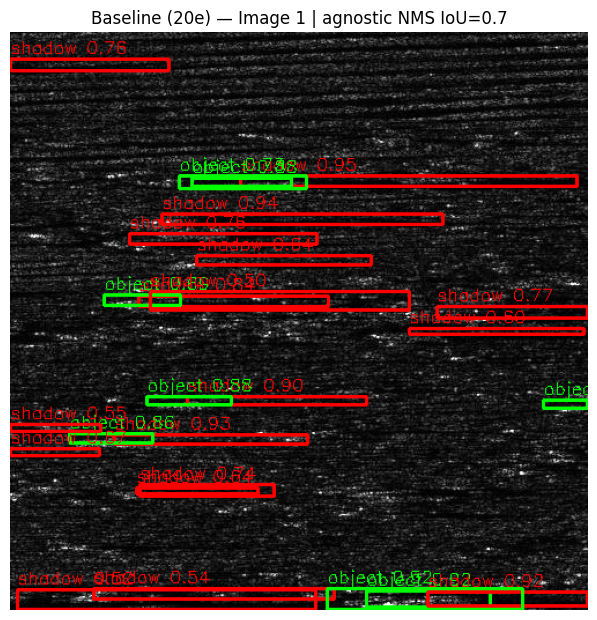

Image 2: shown 15 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


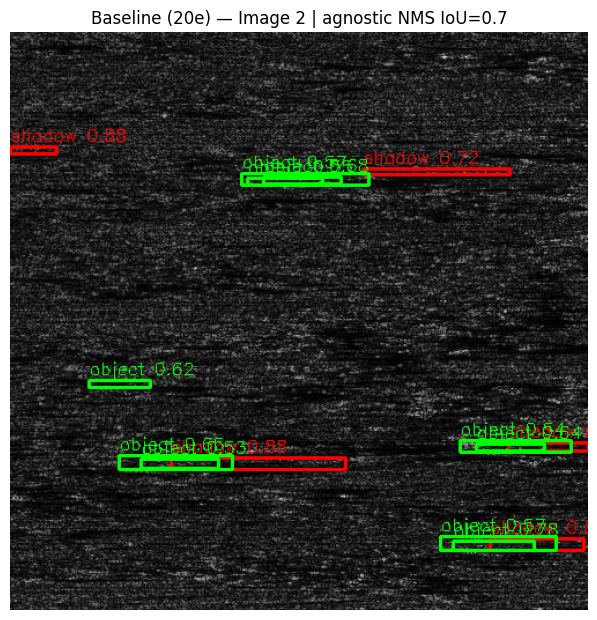

Image 3: shown 46 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


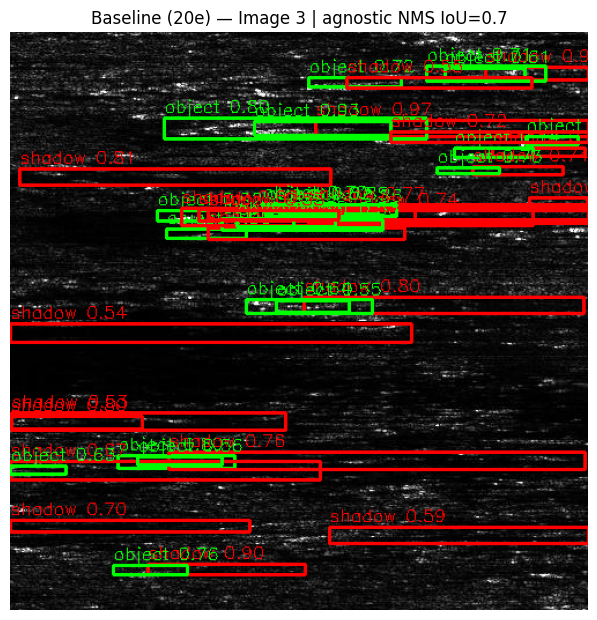

Image 4: shown 20 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


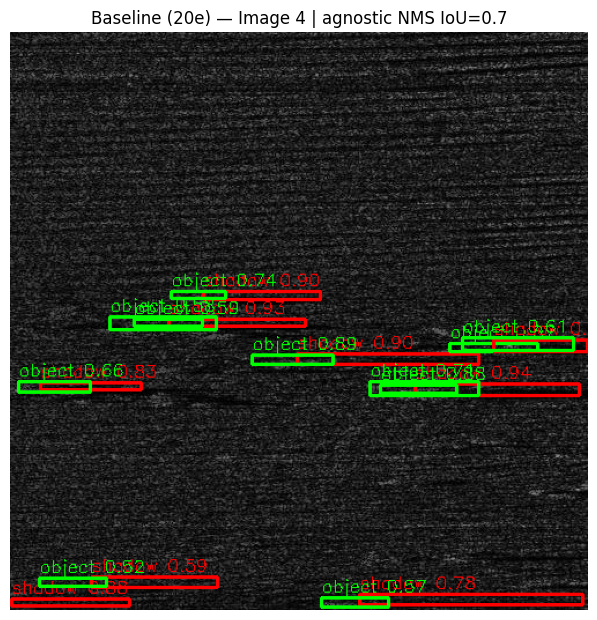

Image 5: shown 8 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


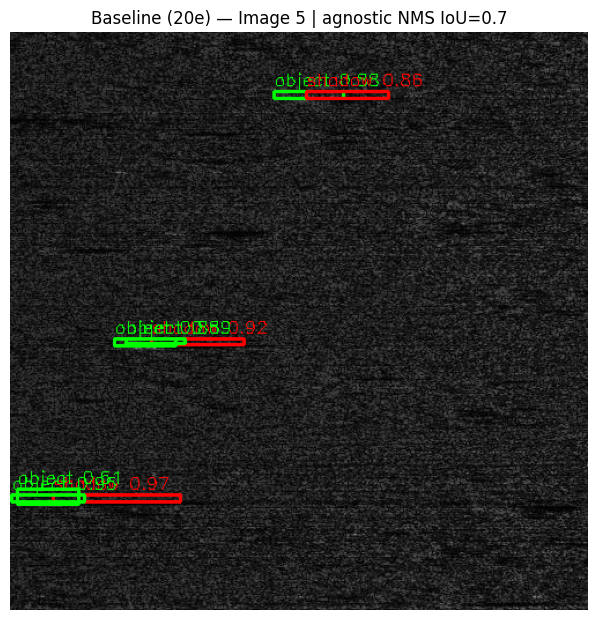

In [4]:
# VISUALIZE PREDICTIONS — Baseline (20 Epochs, Raw Data)
# Note to future me:
# These plots are for *human* sanity-checks only. We are NOT judging
#   the model by "detections per image" (Maria is right) — that belongs
#   in mAP/mAR. Here we just want clean pictures without obvious dupes.
# TorchVision already does per-class NMS inside Faster R-CNN. Extra NMS
#   here is purely for prettier snapshots. I’m keeping a switch so I can
#   choose between class-agnostic (kills cross-class duplicates) and
#   class-wise.
# =============================================================

import sys, torch, cv2, numpy as np, matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.ops import nms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    FasterRCNN_ResNet50_FPN_Weights,
)

# Make the dataset class importable
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

# Config
CONF_THRESH   = 0.5     # show only boxes >= this confidence
IOU_THRESH    = 0.7     # NMS IoU; higher => fewer duplicates in the picture
NMS_MODE      = "agnostic"  # "agnostic" (good for killing dupes) or "classwise"
NUM_IMAGES    = 5
DATASET_ROOT  = "/content/drive/MyDrive/sonar-object-detection/data/line2voc"
CKPT          = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_20epoch.pth"

LABEL_NAMES   = {1: "object", 2: "shadow"}
LABEL_COLORS  = {1: (0, 255, 0), 2: (0, 0, 255)}  # green=object, red=shadow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper: optional extra NMS
def apply_extra_nms(boxes, scores, labels, iou_thresh=0.5, mode="agnostic"):
    """Extra dedup just for visuals. Model has already done per-class NMS.
    mode="agnostic"  -> suppress across classes (reduces 'double boxes' a lot)
    mode="classwise" -> suppress within each class (more conservative)"""
    if boxes.numel() == 0:
        return torch.empty((0,), dtype=torch.long)

    if mode == "classwise":
        keep_idxs = []
        for cls in torch.unique(labels):
            m = labels == cls
            if m.any():
                kept = nms(boxes[m], scores[m], iou_thresh)
                keep_idxs.append(torch.where(m)[0][kept])
        return torch.cat(keep_idxs) if keep_idxs else torch.empty((0,), dtype=torch.long)

    # default: class-agnostic
    return nms(boxes, scores, iou_thresh)

# Model
# Use DEFAULT so the internal transform (resize + ImageNet mean/std) matches training.
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

# Swap the head to 3 classes: bg(0), object(1), shadow(2).
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load trained weights and move to eval
state = torch.load(CKPT, map_location=device)
# tolerate either a bare state_dict or {"model": state_dict}
if isinstance(state, dict) and "model" in state:
    state = state["model"]
model.load_state_dict(state)
model.to(device).eval()

# Visualize a few val images
def visualize(model, dataset_root, num_images, conf_thresh, iou_thresh, nms_mode):
    # Note: VOCDataset + ToTensor() -> image in [0,1]; model handles normalization inside.
    ds = VOCDataset(dataset_root, image_set="val", transforms=ToTensor())

    for idx in range(min(num_images, len(ds))):
        img, _ = ds[idx]
        x = img.unsqueeze(0).to(device)

        with torch.no_grad():
            out = model(x)[0]  # Faster R-CNN returns a dict per image

        # Extra NMS purely for aesthetics (see note above)
        keep = apply_extra_nms(out["boxes"], out["scores"], out["labels"],
                               iou_thresh=iou_thresh, mode=nms_mode)
        boxes  = out["boxes"][keep]
        scores = out["scores"][keep]
        labels = out["labels"][keep]

        # Back to an OpenCV image for drawing
        im = cv2.cvtColor(
            (img.mul(255).byte().permute(1, 2, 0).cpu().numpy()),
            cv2.COLOR_RGB2BGR
        )

        kept_count = 0
        for b, l, s in zip(boxes, labels, scores):
            s = float(s)
            if s < conf_thresh:
                continue
            x1, y1, x2, y2 = b.int().tolist()
            color = LABEL_COLORS.get(int(l), (255, 255, 255))
            name  = LABEL_NAMES.get(int(l), "unknown")

            cv2.rectangle(im, (x1, y1), (x2, y2), color, 2)
            cv2.putText(im, f"{name} {s:.2f}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            kept_count += 1

        # Little heads-up in the console (for me, not for the paper)
        print(f"Image {idx+1}: shown {kept_count} boxes (≥ {conf_thresh:.2f}) "
              f"after {nms_mode} NMS @ IoU={iou_thresh:.2f}")

        # Show with matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Baseline (20e) — Image {idx+1} | {nms_mode} NMS IoU={iou_thresh}")
        plt.tight_layout(pad=0)
        plt.show()

# Shoot
visualize(model, DATASET_ROOT, NUM_IMAGES, CONF_THRESH, IOU_THRESH, NMS_MODE)

# **Faster R-CNN and Start Training with Preprocessed Data**

This is the plain Faster R-CNN baseline trained on the **preprocessed/denoised** version of my VOC-style sonar dataset. The aim is to mirror the raw-baseline recipe and isolate the effect of denoising.

---

## What I’m training

- **Detector:** `fasterrcnn_resnet50_fpn` with the torchvision **DEFAULT** weights  
  (keeps the built-in resize and ImageNet mean/std that I used for fine-tuning).
- **Classes:** background=0, `object`=1, `shadow`=2.
- **Data root:** `line2voc_preprocessed` (same structure as VOC: `JPEGImages/`, `Annotations/`, `ImageSets/Main/*.txt`).

---

## What the code does (end to end)

1. **Mount Drive and set paths**  
   Points `DATASET_DIR` to the denoised dataset.

2. **Dataset loader (VOC style)**  
   - Reads image ids from `ImageSets/Main/{train,val}.txt`.  
   - Parses each `*.xml` to pull bounding boxes and class names.  
   - Maps labels with `{"object": 1, "shadow": 2}` and guards against bad boxes.  
   - If an annotation is truly empty, I return a tiny dummy box with label 0 so the training step doesn’t crash.

3. **Transforms and loaders**  
   - **Train:** `ToImage` -> random horizontal flip -> torchvision’s DEFAULT normalization.  
   - **Val:** `ToImage` -> DEFAULT normalization (no augmentation).  
   - Collate returns lists so Faster R-CNN can consume variable numbers of boxes.

4. **Model setup**  
   - Load `fasterrcnn_resnet50_fpn` with DEFAULT weights.  
   - Replace the classification head with a 3-class predictor (background plus two foreground classes).  
   - Move to GPU if available.

5. **Optimization**  
   - **Optimizer:** AdamW, learning rate `2e-4`, weight decay `1e-4`.  
   - **Scheduler:** cosine annealing for 20 epochs, minimum LR `1e-6`.  
   - **Grad clip:** `max_norm=2.0` to avoid rare spikes.

6. **Training loop (20 epochs)**  
   - Forward pass with the list of images and targets; sum the built-in detection losses.  
   - Backward, clip, optimizer step.  
   - Track and print the average loss per epoch.

7. **Checkpoint**  
   - Save the final weights to  
     `.../checkpoints/baseline_frcnn_preprocessed_20epoch.pth`.

---

## Why these choices

- **DEFAULT weights:** I want the same preprocessing path (resize + normalization) at train time that the backbone expects. It also stabilizes early epochs on small datasets.
- **Light augmentation:** Only a horizontal flip. The main comparison I care about is *denoised vs raw* under a consistent training recipe, not squeezing every percent from augmentation tricks.
- **AdamW + cosine LR:** Simple, robust, and works well for Faster R-CNN fine-tuning on modest datasets.
- **Grad clipping:** Keeps training steady if an odd batch has many crowded boxes.

---

## Tips and gotchas I keep in mind

- **Split files must be valid.** If `train.txt` or `val.txt` references missing images or XMLs, loaders will fail. I have separate split-cleaning utilities for that.
- **Empty or broken XMLs.** The tiny dummy box with label 0 is there to keep the batch moving; I still keep an eye on counts to make sure these are rare.
- **Metrics live elsewhere.** This script only trains and saves weights. I run COCO mAP/mAR with TorchMetrics in a separate eval script so thresholds are swept properly.
- **Preprocessed vs raw.** The point here is apples-to-apples: same model, same hyperparameters, just a different input domain. Any gains should be attributable to denoising, not recipe drift.

---

## Reproducibility checklist

- Fix the random seed if I need exact repeatability of splits and sampling.  
- Log `len(train_ds)` and `len(val_ds)`; sudden changes usually mean a path or split issue.  
- Keep the same `ImageSets/Main/train.txt` and `val.txt` as the raw baseline unless I’m intentionally changing the split.

---

In [ ]:
# Baseline Faster R-CNN (20 epochs) on denoised sonar dataset
# Goal: same logic as raw baseline, just on preprocessed data

from google.colab import drive
drive.mount('/content/drive')   # access dataset from Drive

import os, xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import torchvision.transforms.v2 as T2
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Path to Pascal VOC style denoised sonar dataset
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed"
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT   # pretrained backbone (COCO)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset class (Pascal VOC style)
class VOCDataset(Dataset):
    """
    Custom VOC loader for sonar data.
    Labels:
      object -> 1
      shadow -> 2
    Background handled as 0.
    """

    def __init__(self, root, image_set="train", transforms=None):
        self.root = root
        self.transforms = transforms
        self.image_dir = os.path.join(root, "JPEGImages")
        self.ann_dir   = os.path.join(root, "Annotations")
        with open(os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")) as f:
            self.image_ids = [x.strip() for x in f.readlines()]
        self.class_map = {"object": 1, "shadow": 2}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img = Image.open(os.path.join(self.image_dir, f"{img_id}.jpg")).convert("RGB")

        # parse annotation
        boxes, labels = [], []
        root = ET.parse(os.path.join(self.ann_dir, f"{img_id}.xml")).getroot()
        for obj in root.findall("object"):
            name = obj.find("name").text.strip()
            if name not in self.class_map:
                continue
            bb = obj.find("bndbox")
            xmin, ymin = float(bb.find("xmin").text), float(bb.find("ymin").text)
            xmax, ymax = float(bb.find("xmax").text), float(bb.find("ymax").text)
            if xmax > xmin and ymax > ymin:  # skip bad boxes
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.class_map[name])

        # handle empty annotations
        if not boxes:
            boxes, labels = [[0, 0, 1, 1]], [0]

        target = {
            "boxes":  torch.tensor(boxes,  dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        if self.transforms:
            img = self.transforms(img)
        return img, target

# Data transforms + loaders
train_tfms = T2.Compose([T2.ToImage(), T2.RandomHorizontalFlip(0.5), weights.transforms()])
val_tfms   = T2.Compose([T2.ToImage(), weights.transforms()])

train_ds = VOCDataset(DATASET_DIR, "train", train_tfms)
val_ds   = VOCDataset(DATASET_DIR, "val",   val_tfms)

def collate_fn(batch):
    return list(zip(*batch))

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} images, Val: {len(val_ds)} images")

# Model setup
model = fasterrcnn_resnet50_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)
model.to(device)


# Optimizer + LR scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)


# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0.0
    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        imgs    = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # compute detection losses
        loss_dict = model(imgs, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: avg_loss={avg_loss:.4f}")

# Save final weights
ckpt_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_preprocessed_20epoch.pth"
torch.save(model.state_dict(), ckpt_path)
print(f"Model saved to: {ckpt_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Train: 1366 images, Val: 242 images


Epoch 1/20: 100%|██████████| 171/171 [37:17<00:00, 13.09s/it]


Epoch 1: avg_loss=1.2539


Epoch 2/20: 100%|██████████| 171/171 [00:50<00:00,  3.36it/s]


Epoch 2: avg_loss=1.1771


Epoch 3/20: 100%|██████████| 171/171 [00:50<00:00,  3.37it/s]


Epoch 3: avg_loss=1.1561


Epoch 4/20: 100%|██████████| 171/171 [00:50<00:00,  3.35it/s]


Epoch 4: avg_loss=1.1332


Epoch 5/20: 100%|██████████| 171/171 [00:50<00:00,  3.36it/s]


Epoch 5: avg_loss=1.1182


Epoch 6/20: 100%|██████████| 171/171 [00:50<00:00,  3.36it/s]


Epoch 6: avg_loss=1.1112


Epoch 7/20: 100%|██████████| 171/171 [00:51<00:00,  3.35it/s]


Epoch 7: avg_loss=1.0955


Epoch 8/20: 100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


Epoch 8: avg_loss=1.0852


Epoch 9/20: 100%|██████████| 171/171 [00:50<00:00,  3.39it/s]


Epoch 9: avg_loss=1.0770


Epoch 10/20: 100%|██████████| 171/171 [00:50<00:00,  3.37it/s]


Epoch 10: avg_loss=1.0562


Epoch 11/20: 100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


Epoch 11: avg_loss=1.0405


Epoch 12/20: 100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


Epoch 12: avg_loss=1.0303


Epoch 13/20: 100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


Epoch 13: avg_loss=1.0059


Epoch 14/20: 100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


Epoch 14: avg_loss=0.9942


Epoch 15/20: 100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


Epoch 15: avg_loss=0.9747


Epoch 16/20: 100%|██████████| 171/171 [00:50<00:00,  3.36it/s]


Epoch 16: avg_loss=0.9575


Epoch 17/20: 100%|██████████| 171/171 [00:50<00:00,  3.37it/s]


Epoch 17: avg_loss=0.9426


Epoch 18/20: 100%|██████████| 171/171 [00:50<00:00,  3.37it/s]


Epoch 18: avg_loss=0.9355


Epoch 19/20: 100%|██████████| 171/171 [00:50<00:00,  3.37it/s]


Epoch 19: avg_loss=0.9177


Epoch 20/20: 100%|██████████| 171/171 [00:50<00:00,  3.37it/s]


Epoch 20: avg_loss=0.9106
Model saved to: /content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_preprocessed_20epoch.pth


# **Batch Inference — Faster R-CNN Baseline (20 epochs, **denoised** data)**

Runs my baseline detector across every image in `line2voc_preprocessed/JPEGImages/`, applies **per-class NMS**, writes a **predictions CSV**, and saves **annotated images**. This is the denoised counterpart to the raw-baseline export so I can compare downstream metrics and visuals side by side.

---

## What I’m doing

1. **Load the model**
   - Start from `FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to keep torchvision’s internal resize and normalization consistent with training.
   - Swap the head to a **3-class** predictor: background=0, `object`=1, `shadow`=2.
   - Load the **denoised** baseline checkpoint  
     (`baseline_frcnn_preprocessed_20epoch.pth`).  
     Handles both a plain `state_dict` and a wrapped `{"model": ...}`.

2. **Run inference on the denoised set**
   - Iterate every `*.jpg` in `line2voc_preprocessed/JPEGImages/`.
   - Convert to tensors with `ToTensor` (range [0,1]); the model’s internal preprocessing does the rest.
   - Collect raw `boxes`, `scores`, `labels`.

3. **De-dup for readability**
   - Apply **class-wise NMS** (IoU = **0.50**) to thin out duplicates **within** each class while leaving cross-class overlaps intact.
   - Keep only detections with **score ≥ 0.50** for export and drawing.

4. **Export**
   - **CSV**: `preds_denoised_frcnn_20epoch.csv`  
     Columns: `filename, class_id, class_name, score, xmin, ymin, xmax, ymax`.
   - **Annotated images**: `outputs/vis_denoised_frcnn_20epoch/`  
     Color code: green = `object`, red = `shadow`.

---

## Inputs and outputs (as coded)

- **Inputs**
  - Images: `…/data/line2voc_preprocessed/JPEGImages/`
  - Checkpoint: `…/checkpoints/baseline_frcnn_preprocessed_20epoch.pth`
- **Outputs**
  - CSV: `…/outputs/preds_denoised_frcnn_20epoch.csv`
  - Visuals: `…/outputs/vis_denoised_frcnn_20epoch/`

---

## Key choices

- **Class-wise NMS**: I want to reduce obvious duplicates without erasing cross-class disagreements that can be informative (object vs shadow).
- **Score gate = 0.50**: Reasonable for clean screenshots and a compact CSV. For headline metrics I evaluate from **raw** detector outputs in a separate script.
- **DEFAULT weights**: Keeps the implicit preprocessing path aligned with the backbone I fine-tuned.

---

## Differences vs the raw export

- Data root points to **`line2voc_preprocessed`**.
- Checkpoint is the **denoised** baseline.  
- Everything else (NMS, thresholds, export format) is kept identical for a fair comparison.

---

## Things I check

- The CSV is for analysis and plotting; **COCO mAP/mAR** is computed from **raw** outputs (no custom NMS, no score gate).
- Crowded scenes can still produce close boxes after NMS; that’s fine for visuals.
- If a checkpoint was saved differently, the `{"model": ...}` branch already handles it.

---

In [ ]:
# BATCH INFERENCE — Faster R-CNN Baseline (20 Epochs, Denoised Data)

import cv2, torch, pandas as pd, numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from torchvision.ops import nms
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
)

# Project directories
PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR    = PROJECT_ROOT / "data" / "line2voc_preprocessed" / "JPEGImages"
MODEL_PATH = PROJECT_ROOT / "checkpoints" / "baseline_frcnn_preprocessed_20epoch.pth"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "vis_denoised_frcnn_20epoch"
PRED_CSV   = PROJECT_ROOT / "outputs" / "preds_denoised_frcnn_20epoch.csv"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCORE_THRESH = 0.5
IOU_THRESH   = 0.5   # IoU for class-wise NMS

# Class setup
CLASS_NAMES  = {1: "object", 2: "shadow"}
CLASS_COLORS = {1: (0, 255, 0), 2: (0, 0, 255)}


# class-wise NMS
def class_wise_nms(boxes, scores, labels, iou_threshold=0.5):
    if boxes.numel() == 0:
        return torch.empty((0,), dtype=torch.long)
    keep = []
    for cls in torch.unique(labels):
        mask = (labels == cls)
        if mask.any():
            kept = nms(boxes[mask], scores[mask], iou_threshold)
            keep.append(torch.where(mask)[0][kept])
    return torch.cat(keep) if keep else torch.empty((0,), dtype=torch.long)


# Load model: start from COCO weights, swap head, then load trained checkpoint
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

state = torch.load(MODEL_PATH, map_location=device)
if isinstance(state, dict) and "model" in state:
    state = state["model"]
model.load_state_dict(state)
model.to(device).eval()


# Inference loop
results = []
to_tensor = ToTensor()
image_paths = sorted(IMG_DIR.glob("*.jpg"))
print(f"Running inference on {len(image_paths)} denoised images (class-wise NMS @ IoU={IOU_THRESH})...")

for p in tqdm(image_paths, desc="Inference"):
    img = Image.open(p).convert("RGB")
    x = to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)[0]

    boxes  = out.get("boxes",  torch.empty((0,4))).cpu()
    scores = out.get("scores", torch.empty((0,))).cpu()
    labels = out.get("labels", torch.empty((0,), dtype=torch.long)).cpu()

    keep = class_wise_nms(boxes, scores, labels, IOU_THRESH)
    boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

    # Save predictions
    for b, s, l in zip(boxes, scores, labels):
        if float(s) < SCORE_THRESH:
            continue
        xmin, ymin, xmax, ymax = map(float, b.tolist())
        results.append({
            "filename": p.name,
            "class_id": int(l),
            "class_name": CLASS_NAMES.get(int(l), "unknown"),
            "score": float(s),
            "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax
        })

    # Draw and save annotated image
    im = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for b, s, l in zip(boxes, scores, labels):
        if float(s) < SCORE_THRESH:
            continue
        x1, y1, x2, y2 = map(int, b.tolist())
        color = CLASS_COLORS.get(int(l), (255,255,255))
        name  = CLASS_NAMES.get(int(l), "unknown")
        cv2.rectangle(im, (x1,y1), (x2,y2), color, 2)
        cv2.putText(im, f"{name} ({float(s):.2f})", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    cv2.imwrite(str(OUTPUT_DIR / p.name), im)


# Save all predictions to CSV
pd.DataFrame(results).to_csv(PRED_CSV, index=False)
print(f"\nPredictions saved: {PRED_CSV}\nAnnotated images: {OUTPUT_DIR}")

Running inference on 1788 denoised images (class-wise NMS @ IoU=0.5)...


Inference: 100%|██████████| 1788/1788 [11:17<00:00,  2.64it/s]



Predictions saved: /content/drive/MyDrive/sonar-object-detection/outputs/preds_denoised_frcnn_20epoch.csv
Annotated images: /content/drive/MyDrive/sonar-object-detection/outputs/vis_denoised_frcnn_20epoch


# **Evaluate: Faster R-CNN (20 epochs) on denoised val split**

This script evaluates the denoised-baseline detector on `val` using **TorchMetrics COCO mAP/mAR**. No “detections per image,” no custom filtering. The goal is a clean, reproducible scoreboard that matches the model’s true performance.

---

## What this does

1. **Rebuild the model exactly like training**
   - Init with `FasterRCNN_ResNet50_FPN_Weights.DEFAULT` so torchvision applies the same resize and ImageNet mean/std.
   - Replace the head with a **3-class** predictor: background=0, `object`=1, `shadow`=2.
   - Load `baseline_frcnn_preprocessed_20epoch.pth` (accepts a raw `state_dict` or a `{"model": ...}` wrapper).

2. **Turn off early pruning**
   - `score_thresh = 0.0` so **TorchMetrics** can sweep thresholds internally.
   - `detections_per_img = 300` to avoid capping recall.
   - Keep detector’s internal NMS (`nms_thresh = 0.5`), which is standard for Faster R-CNN.

3. **Run COCO-style evaluation**
   - Iterate the denoised **val** split via my `VOCDataset` wrapper.
   - Build the lists of `preds` and `gts` that **MeanAveragePrecision** expects.
   - Report global metrics (`map`, `map_50`, `map_75`, `mar_100`) and **per-class** scores using the class IDs returned by TorchMetrics.

---

## Inputs and outputs (as coded)

- **Input**
  - Dataset root: `…/data/line2voc_preprocessed`
  - Checkpoint: `…/checkpoints/baseline_frcnn_preprocessed_20epoch.pth`
- **Output**
  - Console printout of COCO metrics (overall and per class)

---

## Why I evaluate this way

- **Thresholds are swept by the metric.** Setting `score_thresh = 0.0` avoids biasing results with an arbitrary cutoff.
- **No custom de-dup for metrics.** Extra NMS and score gates are fine for pretty screenshots, but mAP/mAR should come straight from the model’s outputs (with its standard NMS) and the metric’s matching.
- **Same preprocessing as training.** Using torchvision’s DEFAULT weights ensures the internal transform pipeline matches fine-tuning.

---

## Small implementation notes

- **Post-NMS outputs:** torchvision’s detectors already return post-NMS predictions; COCO mAP still makes sense because metrics operate over score thresholds.
- **Class names:** per-class reporting is mapped from the `classes` tensor returned by TorchMetrics (no hard-coded assumptions).
- **Performance:** `torch.backends.cudnn.benchmark = True` gives a minor speed bump when image sizes are roughly consistent.

---

## Sanity checks I usually do

- Do global numbers look sensible (e.g., `map_50` higher than `map_75`)?
- Are `object` and `shadow` mAP values in a believable range relative to class frequency?
- Did I point at the **denoised** dataset root and the matching checkpoint?

---

In [ ]:
# EVALUATE — Faster R-CNN (20e) on DENOISED val split
# Note to future me:
# This is the *evaluation* script — no counting “detections per image”.
#   We report COCO-style mAP/mAR only.
# I init the detector with DEFAULT weights so the internal preprocessing
#   (resize + ImageNet mean/std) exactly matches training.
# I also drop score_thresh to 0.0 so TorchMetrics can sweep thresholds
#   internally instead of me pruning early.
# Duplicates in visuals are a *visualization* concern. Here we trust the
#   model’s built-in per-class NMS + TorchMetrics’ matching.

import sys, torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    FasterRCNN_ResNet50_FPN_Weights,
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Tiny perf boost when image sizes are consistent-ish
torch.backends.cudnn.benchmark = True


# Dataset: same wrapper everywhere to keep things boring & safe
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset  # class_map: {"object": 1, "shadow": 2}


# Model: DEFAULT weights -> swap head -> load my checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_preprocessed_20epoch.pth"

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

# Head with 3 outputs: bg(0), object(1), shadow(2)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# For eval: let the metric sweep thresholds (don’t prune early)
model.roi_heads.score_thresh = 0.0
model.roi_heads.nms_thresh   = 0.5
model.roi_heads.detections_per_img = 300

# Load weights (tolerate both raw state_dict or {"model": ...})
state = torch.load(ckpt_path, map_location=device)
if isinstance(state, dict) and "model" in state:
    state = state["model"]
model.load_state_dict(state, strict=False)
model.to(device).eval()


# Eval loop on val split
def evaluate(model, dataset_root, image_set="val", batch_size=4, num_workers=2):

    ds = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x)),
        num_workers=num_workers,
        pin_memory=True,
    )

    metric = MeanAveragePrecision(class_metrics=True)

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outs = model(imgs)

            preds = [
                {"boxes":  o["boxes"].cpu(),
                 "scores": o["scores"].cpu(),
                 "labels": o["labels"].cpu()}
                for o in outs
            ]
            gts = [
                {"boxes":  t["boxes"].cpu(),
                 "labels": t["labels"].cpu()}
                for t in targets
            ]
            metric.update(preds, gts)

    res = metric.compute()


    # Pretty-print the scoreboard
    print("\nEvaluation: Faster R-CNN (20e, Denoised Data) "
          f"[split={image_set}, batch={batch_size}]")
    for k, v in res.items():
        if isinstance(v, torch.Tensor) and v.numel() == 1:
            print(f"{k}: {v.item():.4f}")
        else:
            print(f"{k}: {v}")


    # Per-class scores
    id_to_name = {1: "object", 2: "shadow"}
    cls_ids = res.get("classes")
    map_pc  = res.get("map_per_class")
    mar_pc  = res.get("mar_100_per_class")

    if isinstance(cls_ids, torch.Tensor) and isinstance(map_pc, torch.Tensor):
        print("\nPer-class mAP:")
        for i, cid in enumerate(cls_ids.tolist()):
            name = id_to_name.get(cid, str(cid))
            print(f"  {name}: {map_pc[i].item():.4f}")

    if isinstance(cls_ids, torch.Tensor) and isinstance(mar_pc, torch.Tensor):
        print("\nPer-class Recall (mAR@100):")
        for i, cid in enumerate(cls_ids.tolist()):
            name = id_to_name.get(cid, str(cid))
            print(f"  {name}: {mar_pc[i].item():.4f}")

# Fire
evaluate(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed",
    image_set="val",
    batch_size=4,
)


Evaluation: Faster R-CNN (20e, Denoised Data) [split=val, batch=4]
map: 0.0460
map_50: 0.1805
map_75: 0.0089
map_small: 0.0328
map_medium: 0.0655
map_large: 0.0115
mar_1: 0.0220
mar_10: 0.1029
mar_100: 0.1667
mar_small: 0.1196
mar_medium: 0.2463
mar_large: 0.5300
map_per_class: tensor([0.0328, 0.0593])
mar_100_per_class: tensor([0.1370, 0.1963])
classes: tensor([1, 2], dtype=torch.int32)

Per-class mAP:
  object: 0.0328
  shadow: 0.0593

Per-class Recall (mAR@100):
  object: 0.1370
  shadow: 0.1963


# **Visualize Predictions — Baseline (20 epochs, denoised data)**

This script is for quick, human sanity-checks. It rebuilds the baseline Faster R-CNN exactly like training, loads the **denoised** checkpoint, runs on a handful of `val` images, and draws boxes. Any extra NMS here is just to make pictures easier to read. Metrics live elsewhere.

---

## What it does

- **Model setup**
  - Init with `FasterRCNN_ResNet50_FPN_Weights.DEFAULT` so torchvision applies the same resize and ImageNet mean/std used during fine-tuning.
  - Swap in a **3-class** head: background=0, `object`=1, `shadow`=2.
  - Load `baseline_frcnn_preprocessed_20epoch.pth` (supports raw `state_dict` or `{"model": ...}`).

- **Run a few `val` images**
  - Uses my `VOCDataset` wrapper and `ToTensor()` (images in `[0,1]`; the model handles the rest).
  - Collects `boxes`, `scores`, `labels` from the model’s output.

- **Optional extra NMS (visuals only)**
  - `NMS_MODE="agnostic"`: suppress duplicates across classes (aggressive; cleaner snapshots).
  - `NMS_MODE="classwise"`: suppress within each class only (conservative; keeps cross-class overlaps).
  - Confidence gate at `CONF_THRESH=0.5` just controls what gets drawn.

- **Draw and show**
  - Green for `object`, red for `shadow`.
  - Prints a small summary per image with how many boxes were shown and the settings used.

---

## Knobs I can tweak at the top

- `CONF_THRESH` — draw boxes only at or above this score (default `0.5`).
- `IOU_THRESH` — IoU used by the extra NMS for visuals (default `0.7`).
- `NMS_MODE` — `"agnostic"` or `"classwise"`.
- `NUM_IMAGES` — how many `val` images to preview.
- `DATASET_ROOT`, `CKPT` — paths for the denoised split and its checkpoint.

---

## Why keep this separate from evaluation

- The detector already performs per-class NMS internally; adding another pass here is just to de-clutter screenshots.
- Scores, precision/recall, mAP and mAR are computed in the **evaluation** scripts. This file is for looking at pictures, not for making claims about accuracy.

---

## Practical tips

- If I care about cross-class disagreements, use `NMS_MODE="classwise"` so a shadow and its adjacent object can both appear.
- If I see obvious double boxes, try a higher `IOU_THRESH` or the agnostic mode.
- If nothing draws, check the checkpoint path and confirm the class head has three outputs.

---

Image 1: shown 30 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


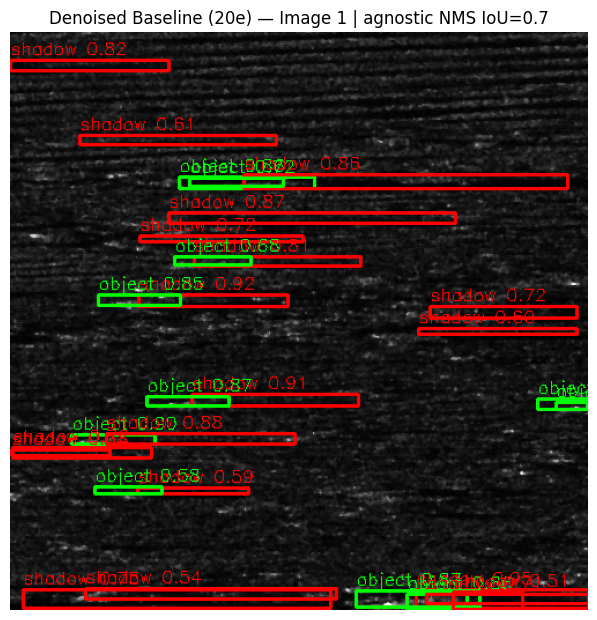

Image 2: shown 13 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


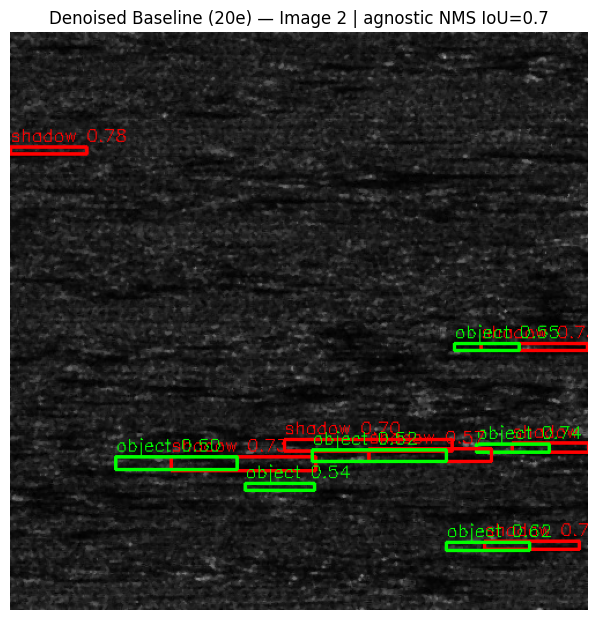

Image 3: shown 48 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


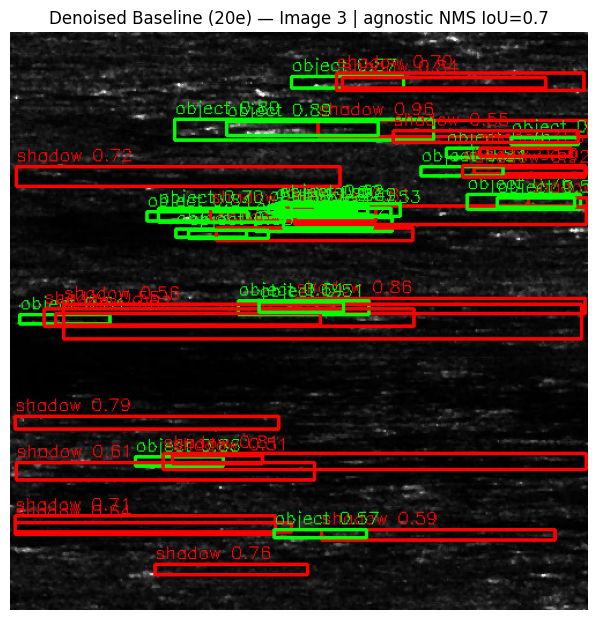

Image 4: shown 17 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


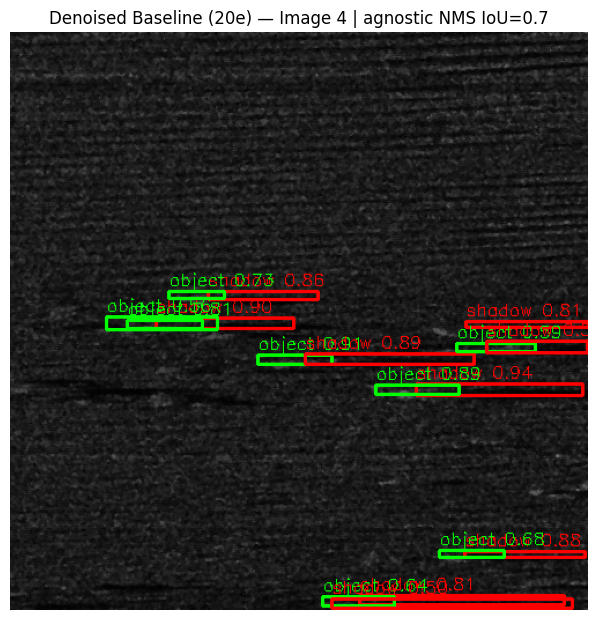

Image 5: shown 9 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


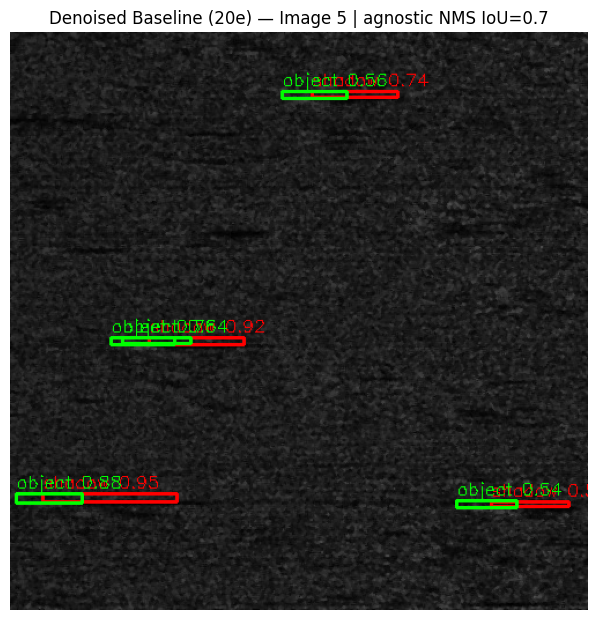

In [5]:
# VISUALIZE PREDICTIONS — Baseline (20 Epochs, Denoised Data)
# Note to future me:
# These plots are for *human* sanity-checks only. We are NOT judging
#   the model by "detections per image" — that belongs
#   in mAP/mAR. Here we just want clean pictures without obvious dupes.
# TorchVision already does per-class NMS inside Faster R-CNN. Extra NMS
#   here is purely for prettier snapshots. I’m keeping a switch so I can
#   choose between class-agnostic (kills cross-class duplicates) and
#   class-wise (safer if overlapping classes are legit).

import sys, torch, cv2, numpy as np, matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.ops import nms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    FasterRCNN_ResNet50_FPN_Weights,
)

# Make the dataset class importable
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

# Config
CONF_THRESH   = 0.5     # show only boxes >= this confidence
IOU_THRESH    = 0.7     # NMS IoU; higher => fewer duplicates in the picture
NMS_MODE      = "agnostic"  # "agnostic" (good for killing dupes) or "classwise"
NUM_IMAGES    = 5
# (denoised/preprocessed split + its checkpoint)
DATASET_ROOT  = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed"
CKPT          = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_preprocessed_20epoch.pth"

LABEL_NAMES   = {1: "object", 2: "shadow"}
LABEL_COLORS  = {1: (0, 255, 0), 2: (0, 0, 255)}  # green=object, red=shadow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# optional extra NMS
def apply_extra_nms(boxes, scores, labels, iou_thresh=0.5, mode="agnostic"):
    """Extra dedup just for visuals. Model has already done per-class NMS.
    mode="agnostic"  -> suppress across classes (reduces 'double boxes' a lot)
    mode="classwise" -> suppress within each class (more conservative)"""
    if boxes.numel() == 0:
        return torch.empty((0,), dtype=torch.long)

    if mode == "classwise":
        keep_idxs = []
        for cls in torch.unique(labels):
            m = labels == cls
            if m.any():
                kept = nms(boxes[m], scores[m], iou_thresh)
                keep_idxs.append(torch.where(m)[0][kept])
        return torch.cat(keep_idxs) if keep_idxs else torch.empty((0,), dtype=torch.long)

    # default: class-agnostic
    return nms(boxes, scores, iou_thresh)

# Model
# Use DEFAULT so the internal transform (resize + ImageNet mean/std) matches training.
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

# Swap the head to 3 classes: bg(0), object(1), shadow(2).
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load trained weights and move to eval
state = torch.load(CKPT, map_location=device)
# tolerate either a bare state_dict or {"model": state_dict}
if isinstance(state, dict) and "model" in state:
    state = state["model"]
model.load_state_dict(state)
model.to(device).eval()


# Visualize a few val images
def visualize(model, dataset_root, num_images, conf_thresh, iou_thresh, nms_mode):
    # Note: VOCDataset + ToTensor() -> image in [0,1]; model handles normalization inside.
    ds = VOCDataset(dataset_root, image_set="val", transforms=ToTensor())

    for idx in range(min(num_images, len(ds))):
        img, _ = ds[idx]
        x = img.unsqueeze(0).to(device)

        with torch.no_grad():
            out = model(x)[0]  # Faster R-CNN returns a dict per image

        # Extra NMS purely for aesthetics (see note above)
        keep = apply_extra_nms(out["boxes"], out["scores"], out["labels"],
                               iou_thresh=iou_thresh, mode=nms_mode)
        boxes  = out["boxes"][keep]
        scores = out["scores"][keep]
        labels = out["labels"][keep]

        # Back to an OpenCV image for drawing
        im = cv2.cvtColor(
            (img.mul(255).byte().permute(1, 2, 0).cpu().numpy()),
            cv2.COLOR_RGB2BGR
        )

        kept_count = 0
        for b, l, s in zip(boxes, labels, scores):
            s = float(s)
            if s < conf_thresh:
                continue
            x1, y1, x2, y2 = b.int().tolist()
            color = LABEL_COLORS.get(int(l), (255, 255, 255))
            name  = LABEL_NAMES.get(int(l), "unknown")

            cv2.rectangle(im, (x1, y1), (x2, y2), color, 2)
            cv2.putText(im, f"{name} {s:.2f}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            kept_count += 1

        # Little heads-up in the console (for me, not for the paper)
        print(f"Image {idx+1}: shown {kept_count} boxes (≥ {conf_thresh:.2f}) "
              f"after {nms_mode} NMS @ IoU={iou_thresh:.2f}")

        # Show with matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Denoised Baseline (20e) — Image {idx+1} | {nms_mode} NMS IoU={iou_thresh}")
        plt.tight_layout(pad=0)
        plt.show()

# Shoot
visualize(model, DATASET_ROOT, NUM_IMAGES, CONF_THRESH, IOU_THRESH, NMS_MODE)

# **Preprocess: CLAHE + optional H-flip + small rotation + jitter**

This pipeline builds a denoised and lightly augmented copy of my VOC dataset. It writes images and XMLs into a new `line2voc_preprocessed_augmented` tree, keeps train/val/test split files in sync, and applies the same geometric transforms to both pixels and boxes.

---

## What this script does

- **Clears output folders**  
  Creates `JPEGImages`, `Annotations`, and `ImageSets/Main` under `line2voc_preprocessed_augmented` and removes any existing files there. I run this only when I mean to fully regenerate the set.

- **Sets seeds**  
  `random.seed(42)` and `np.random.seed(42)` so flips, rotations, and jitter are reproducible.

- **Per image**  
  1) **Median blur (k=3)** to reduce speckle without destroying edges.  
  2) **CLAHE** on the L channel (in LAB space) to improve local contrast while limiting amplification of noise.  
  3) **Optional horizontal flip** with probability 0.5.  
  4) **Small in-place rotation** around the image center, random angle in [−10°, 10°], same canvas size, reflected borders.  
  5) **Mild brightness/contrast jitter** (contrast in [0.9, 1.1], brightness offset about ±10).

- **Annotation sync**  
  - Flip: swap xmin/xmax around the image width.  
  - Rotation: apply the same 2x3 affine matrix to all four box corners, then take min/max to get a new axis-aligned box and clamp to image bounds.

- **Writes outputs**  
  - Processed image to `DEST_IMG_DIR`.  
  - Updated XML to `DEST_ANN_DIR`.  
  - Copies split files from the source dataset to the destination unchanged.

---

## Why these choices

- **Median blur first**  
  Sonar is speckly; a small median filter cleans it up with minimal edge loss.

- **CLAHE in LAB**  
  Operating on the luminance channel boosts contrast without pushing colors into odd tones.

- **Horizontal flip**  
  Cheap diversity. It is safe for this task because left-right mirroring does not change the class semantics of object vs shadow.

- **Small rotation, same canvas**  
  Keeps dimensions constant for downstream tooling. The affine uses border reflection to avoid black wedges at the corners.

- **Axis-aligned boxes after rotation**  
  Using corner transform plus min/max keeps boxes in VOC’s axis-aligned format. It slightly overestimates rotated objects, which is acceptable for small angles here.

- **Clamping boxes**  
  Any numerical drift or corners that land outside the frame get pushed back into valid range, and degenerate boxes are widened to at least 1 pixel.

---

## Inputs and outputs

- **Source**
  - Images: `.../data/line2voc/JPEGImages`
  - Annotations: `.../data/line2voc/Annotations`
  - Splits: `.../data/line2voc/ImageSets/Main/*.txt`

- **Destination**
  - Images: `.../data/line2voc_preprocessed_augmented/JPEGImages`
  - Annotations: `.../data/line2voc_preprocessed_augmented/Annotations`
  - Splits: copied to `.../data/line2voc_preprocessed_augmented/ImageSets/Main`

---

## Sanity checks I usually run

- **Count parity**  
  Number of written images equals number of written XMLs.  
- **Spot-check a few samples**  
  Visualize boxes before and after to confirm flip and rotation alignment.  
- **IOU drift after rotation**  
  For small angles the IOU between original and transformed box is reasonable; if not, reduce the angle range.  
- **Missing XMLs**  
  The script logs when an image lacks an annotation file; I decide whether to exclude that image entirely to keep splits consistent.

---

## Gotchas and how I handle them

- **Destructive regen**  
  The destination folders are wiped at start. If I need older runs, I change `DEST_ROOT` or back up first.

- **Over-tight jitter**  
  Large brightness/contrast jitter can create unrealistic sonar. I keep it mild here.

- **Axis-aligned after rotation**  
  AABBs inflate slightly compared to a true rotated box. Acceptable for ±10°. For larger rotations consider rotated boxes or polygon masks.

- **Different image sizes**  
  Rotation is done with `warpAffine` at the original size, so no dimension surprises later.

---

In [ ]:
# PREPROCESS: CLAHE + optional H-flip + small rotation + jitter
import os, cv2, shutil, random, numpy as np, xml.etree.ElementTree as ET
from pathlib import Path
from tqdm import tqdm

# Paths
PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")

SRC_IMG_DIR   = PROJECT_ROOT / "data" / "line2voc" / "JPEGImages"
SRC_ANN_DIR   = PROJECT_ROOT / "data" / "line2voc" / "Annotations"
SRC_SPLIT_DIR = PROJECT_ROOT / "data" / "line2voc" / "ImageSets" / "Main"

DEST_ROOT     = PROJECT_ROOT / "data" / "line2voc_preprocessed_augmented"
DEST_IMG_DIR  = DEST_ROOT / "JPEGImages"
DEST_ANN_DIR  = DEST_ROOT / "Annotations"
DEST_SPLIT_DIR= DEST_ROOT / "ImageSets" / "Main"

for d in (DEST_IMG_DIR, DEST_ANN_DIR, DEST_SPLIT_DIR):
    d.mkdir(parents=True, exist_ok=True)
    for f in d.glob("*"): f.unlink()
print("Cleared previous outputs.")

# Reproducibility
random.seed(42)
np.random.seed(42)

# Helpers
def apply_clahe(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)

def parse_boxes(tree):
    """Return list of (node, xmin, ymin, xmax, ymax)."""
    root = tree.getroot()
    out = []
    for obj in root.findall("object"):
        bb = obj.find("bndbox")
        xmin = float(bb.find("xmin").text); ymin = float(bb.find("ymin").text)
        xmax = float(bb.find("xmax").text); ymax = float(bb.find("ymax").text)
        out.append((bb, xmin, ymin, xmax, ymax))
    return out

def clamp_box(xmin, ymin, xmax, ymax, w, h):
    xmin = max(0.0, min(xmin, w-1))
    xmax = max(0.0, min(xmax, w-1))
    ymin = max(0.0, min(ymin, h-1))
    ymax = max(0.0, min(ymax, h-1))
    # ensure non-degenerate
    if xmax <= xmin: xmax = min(w-1.0, xmin + 1.0)
    if ymax <= ymin: ymax = min(h-1.0, ymin + 1.0)
    return xmin, ymin, xmax, ymax

def apply_flip_to_boxes(tree, w):
    for bb, xmin, ymin, xmax, ymax in parse_boxes(tree):
        nxmin = w - xmax
        nxmax = w - xmin
        bb.find("xmin").text = str(int(round(nxmin)))
        bb.find("xmax").text = str(int(round(nxmax)))

def apply_rotation_to_boxes(tree, M, w, h):
    """
    Apply 2x3 affine M (same used for image warping) to each box by transforming
    the 4 corners and taking min/max. Keep inside [0, w) x [0, h).
    """
    def transform_pts(pts):
        pts = np.asarray(pts, dtype=np.float32)  # (N,2)
        ones = np.ones((pts.shape[0], 1), dtype=np.float32)
        pts_h = np.hstack([pts, ones])          # (N,3)
        out = (M @ pts_h.T).T                    # (N,2)
        return out

    for bb, xmin, ymin, xmax, ymax in parse_boxes(tree):
        corners = [(xmin, ymin), (xmax, ymin), (xmin, ymax), (xmax, ymax)]
        rot = transform_pts(corners)
        rxmin, rymin = rot[:,0].min(), rot[:,1].min()
        rxmax, rymax = rot[:,0].max(), rot[:,1].max()
        rxmin, rymin, rxmax, rymax = clamp_box(rxmin, rymin, rxmax, rymax, w, h)
        bb.find("xmin").text = str(int(round(rxmin)))
        bb.find("ymin").text = str(int(round(rymin)))
        bb.find("xmax").text = str(int(round(rxmax)))
        bb.find("ymax").text = str(int(round(rymax)))


# Main loop
count = 0
for img_path in tqdm(sorted(SRC_IMG_DIR.glob("*.jpg")), desc="Processing"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Skip unreadable: {img_path.name}")
        continue
    h, w = img.shape[:2]

    # 1) light denoise
    img = cv2.medianBlur(img, 3)

    # 2) CLAHE
    img = apply_clahe(img)

    # 3) optional horizontal flip
    flipped = random.random() < 0.5
    if flipped:
        img = cv2.flip(img, 1)

    # 4) small rotation around center that also keep same canvas size
    angle = random.uniform(-10, 10)
    M = cv2.getRotationMatrix2D((w/2.0, h/2.0), angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT101)

    # 5) mild brightness/contrast jitter
    brightness = random.uniform(0.9, 1.1)
    contrast   = random.uniform(0.9, 1.1)
    img = np.clip(contrast * img + brightness * 10, 0, 255).astype(np.uint8)

    # Save image
    out_img = DEST_IMG_DIR / img_path.name
    cv2.imwrite(str(out_img), img)

    # ---- annotations ----
    ann_src = SRC_ANN_DIR / f"{img_path.stem}.xml"
    if not ann_src.exists():
        print(f"Missing XML for {img_path.name} — skipping ann.")
        continue

    tree = ET.parse(ann_src)

    # apply same transforms to boxes, in the same order:
    if flipped:
        apply_flip_to_boxes(tree, w)
    apply_rotation_to_boxes(tree, M, w, h)

    # write XML
    (DEST_ANN_DIR / f"{img_path.stem}.xml").write_text(
        ET.tostring(tree.getroot(), encoding="unicode")
    )

    count += 1

print(f"{count} images written to {DEST_IMG_DIR}")

# Copy splits as it is
for f in SRC_SPLIT_DIR.glob("*.txt"):
    shutil.copy(f, DEST_SPLIT_DIR)
print("Splits copied.")
print(f"Done -> {DEST_ROOT}")

Cleared previous outputs.


Processing: 100%|██████████| 1788/1788 [01:01<00:00, 29.20it/s]


1788 images written to /content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented/JPEGImages
Splits copied.
Done -> /content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented


# **Train Faster R-CNN (20 epochs) — CLAHE + Augmented Sonar**

This script fine-tunes a **Faster R-CNN ResNet50 FPN** detector on the **preprocessed + lightly augmented** VOC-style sonar dataset. It mirrors the raw-baseline training setup, but points to the `line2voc_preprocessed_augmented` tree created by the preprocessing pipeline.

---

## What this script does

- **Mounts Drive** so the dataset and checkpoints are accessible in Colab.
- **Sanity-checks splits**: verifies that every ID listed in `train.txt` and `val.txt` has a corresponding `.jpg` in `JPEGImages/`. Training aborts early if a split references missing images.
- **Loads a minimal VOC dataset wrapper** with a class map:
  - background is implicit (index 0, handled internally by the detector),
  - `object` has label 1,
  - `shadow` has label 2.
  A small fallback (1×1 box with label 0) keeps the loader from crashing if an annotation is empty.
- **Applies transforms** consistent with torchvision’s built-in preprocessing:
  - `ToImage()` to tensor,
  - `RandomHorizontalFlip(p=0.5)` on the train set,
  - `weights.transforms()` to keep resize and ImageNet mean/std aligned with the pretrained backbone.
- **Builds the model**:
  - starts from `FasterRCNN_ResNet50_FPN_Weights.DEFAULT`,
  - replaces the detection head with a **3-class** predictor (bg, object, shadow).
- **Optimizes for 20 epochs** with:
  - **AdamW** (`lr=2e-4`, `weight_decay=1e-4`),
  - **CosineAnnealingLR** (T_max=20, `eta_min=1e-6`),
  - **gradient clipping** at `max_norm=2.0`.
- **Trains and logs** the average loss per epoch.
- **Saves a final checkpoint** to Drive.

---

## Data and paths

- **Dataset root**:  
  `/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented`
- **Splits** (expected present and valid):  
  `ImageSets/Main/train.txt`, `ImageSets/Main/val.txt`
- **Images/Annotations**:  
  `JPEGImages/*.jpg`, `Annotations/*.xml`
- **Checkpoint output**:  
  `.../checkpoints/baseline_frcnn_claheaug_20epoch.pth`

---

## Key choices (and why)

- **DEFAULT weights**  
  Keeps resize and normalization exactly as expected by the pretrained backbone that is being fine-tuned.
- **Flip on train only**  
  `RandomHorizontalFlip` adds cheap variety without distorting evaluation. Validation uses deterministic transforms.
- **AdamW + cosine schedule**  
  Stable fine-tuning defaults that work well for detection at this scale. Cosine annealing gives a smooth decay across 20 epochs.
- **Gradient clipping**  
  Caps occasional spikes and keeps training stable, especially when annotation quality varies.
- **Split integrity checks**  
  Catch split issues early instead of failing mid-epoch.

---

## How I usually run and validate

1. **Kick off training** and watch `avg_loss` trend down each epoch.
2. **Save checkpoint** (done automatically at epoch 20).
3. **Evaluate on val** with the dedicated evaluation script (COCO mAP/mAR via TorchMetrics). Keep score-threshold at zero in eval to let the metric sweep operating points.
4. **Spot-check visuals** with the visualize-predictions script (a handful of images, extra NMS only for readability).

---

## Common pitfalls and quick fixes

- **Missing images referenced in splits**  
  The script asserts before training starts. If this triggers, rebuild the split files or copy missing images.
- **Empty or malformed XML**  
  The dataset wrapper has a safe fallback for empty annotations. For repeated issues, fix or drop the offending samples.
- **Memory pressure**  
  If you run out of memory, lower the batch size in the DataLoader and consider reducing workers.
- **Mismatch in class labels**  
  Ensure XML labels are exactly `object` or `shadow`. Anything else is skipped.

---

## Hyperparameters at a glance

- Epochs: **20**
- Batch size: **8** (train and val)
- Optimizer: **AdamW** (`lr=2e-4`, `wd=1e-4`)
- Scheduler: **CosineAnnealingLR** (T_max=20, `eta_min=1e-6`)
- Grad clip: **2.0**
- Transforms (train): `ToImage`, `RandomHorizontalFlip(0.5)`, `weights.transforms()`
- Transforms (val): `ToImage`, `weights.transforms()`

---

In [ ]:
# TRAIN FASTER R-CNN (20 EPOCHS): CLAHE + Augmented Sonar

# --- Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Imports ---
import os
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

import torchvision.transforms.v2 as T2
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    FasterRCNN_ResNet50_FPN_Weights,
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# --- Dataset root ---
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented"


# Split sanity check
def _missing_in_split(txt_file: Path, image_dir: Path):
    with open(txt_file) as f:
        ids = [x.strip() for x in f.readlines()]
    return [i for i in ids if not (image_dir / f"{i}.jpg").exists()]

split_dir = Path(DATASET_DIR) / "ImageSets" / "Main"
image_dir = Path(DATASET_DIR) / "JPEGImages"

missing_train = _missing_in_split(split_dir / "train.txt", image_dir)
missing_val   = _missing_in_split(split_dir / "val.txt",   image_dir)

assert not missing_train, f"Missing train images: {missing_train[:5]}..."
assert not missing_val,   f"Missing val images: {missing_val[:5]}..."
print("Splits look good: all listed images exist.")


# Minimal VOCDataset
class VOCDataset(Dataset):
    def __init__(self, root, image_set="train", transforms=None):
        self.root = root
        self.transforms = transforms
        self.image_dir = os.path.join(root, "JPEGImages")
        self.ann_dir   = os.path.join(root, "Annotations")
        with open(os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")) as f:
            self.image_ids = [x.strip() for x in f.readlines()]
        self.class_map = {"object": 1, "shadow": 2}  # 0 is background

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id  = self.image_ids[idx]
        img     = Image.open(os.path.join(self.image_dir, f"{img_id}.jpg")).convert("RGB")
        ann_xml = os.path.join(self.ann_dir,  f"{img_id}.xml")

        boxes, labels = [], []
        root = ET.parse(ann_xml).getroot()
        for obj in root.findall("object"):
            name = obj.find("name").text.strip()
            label = self.class_map.get(name)
            if label is None:
                continue
            bb = obj.find("bndbox")
            xmin = int(float(bb.find("xmin").text))
            ymin = int(float(bb.find("ymin").text))
            xmax = int(float(bb.find("xmax").text))
            ymax = int(float(bb.find("ymax").text))
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(label)

        if not boxes:
            boxes, labels = [[0, 0, 1, 1]], [0]  # safe fallback

        target = {
            "boxes":  torch.tensor(boxes,  dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        if self.transforms:
            img = self.transforms(img)
        return img, target


# Transforms + loaders
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

train_tfms = T2.Compose([
    T2.ToImage(),
    T2.RandomHorizontalFlip(p=0.5),
    weights.transforms(),  # resize/normalize to match model.transform
])

val_tfms = T2.Compose([
    T2.ToImage(),
    weights.transforms(),
])

train_ds = VOCDataset(DATASET_DIR, image_set="train", transforms=train_tfms)
val_ds   = VOCDataset(DATASET_DIR, image_set="val",   transforms=val_tfms)

def collate_fn(batch):
    # detector expects: list[Tensor], list[Dict]
    return list(zip(*batch))

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device} | Train: {len(train_ds)} | Val: {len(val_ds)}")


# Model
model = fasterrcnn_resnet50_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)
model.to(device)


# Optimizer, scheduler, grad clipping
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)


# Training loop — 20 epochs
for epoch in range(20):
    model.train()
    running = 0.0

    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        imgs    = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        running += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}: avg_loss={running/len(train_loader):.4f}")


# Save checkpoint
ckpt = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_claheaug_20epoch.pth"
torch.save(model.state_dict(), ckpt)
print(f"Model saved: {ckpt}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Splits look good: all listed images exist.
Device: cuda | Train: 1366 | Val: 242


Epoch 1/20: 100%|██████████| 171/171 [00:49<00:00,  3.43it/s]


Epoch 1: avg_loss=1.1675


Epoch 2/20: 100%|██████████| 171/171 [00:49<00:00,  3.45it/s]


Epoch 2: avg_loss=1.1106


Epoch 3/20: 100%|██████████| 171/171 [00:49<00:00,  3.45it/s]


Epoch 3: avg_loss=1.0962


Epoch 4/20: 100%|██████████| 171/171 [00:49<00:00,  3.45it/s]


Epoch 4: avg_loss=1.0940


Epoch 5/20: 100%|██████████| 171/171 [00:49<00:00,  3.45it/s]


Epoch 5: avg_loss=1.0894


Epoch 6/20: 100%|██████████| 171/171 [00:49<00:00,  3.45it/s]


Epoch 6: avg_loss=1.0756


Epoch 7/20: 100%|██████████| 171/171 [00:49<00:00,  3.45it/s]


Epoch 7: avg_loss=1.0748


Epoch 8/20: 100%|██████████| 171/171 [00:49<00:00,  3.43it/s]


Epoch 8: avg_loss=1.0648


Epoch 9/20: 100%|██████████| 171/171 [00:50<00:00,  3.41it/s]


Epoch 9: avg_loss=1.0507


Epoch 10/20: 100%|██████████| 171/171 [00:49<00:00,  3.43it/s]


Epoch 10: avg_loss=1.0414


Epoch 11/20: 100%|██████████| 171/171 [00:49<00:00,  3.42it/s]


Epoch 11: avg_loss=1.0230


Epoch 12/20: 100%|██████████| 171/171 [00:49<00:00,  3.42it/s]


Epoch 12: avg_loss=1.0116


Epoch 13/20: 100%|██████████| 171/171 [00:49<00:00,  3.44it/s]


Epoch 13: avg_loss=1.0051


Epoch 14/20: 100%|██████████| 171/171 [00:49<00:00,  3.43it/s]


Epoch 14: avg_loss=0.9894


Epoch 15/20: 100%|██████████| 171/171 [00:49<00:00,  3.44it/s]


Epoch 15: avg_loss=0.9748


Epoch 16/20: 100%|██████████| 171/171 [00:49<00:00,  3.44it/s]


Epoch 16: avg_loss=0.9613


Epoch 17/20: 100%|██████████| 171/171 [00:49<00:00,  3.43it/s]


Epoch 17: avg_loss=0.9470


Epoch 18/20: 100%|██████████| 171/171 [00:50<00:00,  3.42it/s]


Epoch 18: avg_loss=0.9304


Epoch 19/20: 100%|██████████| 171/171 [00:49<00:00,  3.43it/s]


Epoch 19: avg_loss=0.9271


Epoch 20/20: 100%|██████████| 171/171 [00:49<00:00,  3.44it/s]


Epoch 20: avg_loss=0.9244
Model saved: /content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_claheaug_20epoch.pth


# Batch Inference — Faster R-CNN Baseline (20 epochs, CLAHE + Augmented data)

This script runs my baseline detector across **all images in** `line2voc_preprocessed_augmented/JPEGImages`, applies **per-class NMS**, writes a **predictions CSV**, and saves **annotated images** for quick visual checks. It is the post-training export I use before computing mAP/mAR or drawing FROC curves.

---

## What this script does

1. **Loads the model**
   - Uses `FasterRCNN_ResNet50_FPN_Weights.DEFAULT` so torchvision’s internal resize and normalization match training.
   - Replaces the classification head with a **3-class** head: background is index 0 (implicit), `object` is 1, `shadow` is 2.
   - Restores the checkpoint from the CLAHE+Aug run (handles both a plain `state_dict` and a wrapped `{"model": ...}`).

2. **Runs inference over the dataset**
   - Iterates every `*.jpg` in the augmented `JPEGImages` folder.
   - Converts each image with `ToTensor()`; the detector’s internal transform handles normalization.
   - Collects raw `boxes`, `scores`, and `labels` for each image.

3. **Deduplicates for readability (not for metrics)**
   - Applies **class-wise NMS** with IoU set to `0.50`. This collapses obvious duplicates within each class while keeping potential cross-class disagreements.

4. **Exports**
   - **CSV** (`preds_claheaug_frcnn_20epoch.csv`): one row per kept detection with columns  
     `filename, class_id, class_name, score, xmin, ymin, xmax, ymax`.
   - **Annotated images** (`outputs/vis_claheaug_frcnn_20epoch/`): green for `object`, red for `shadow`. Only detections with score at least `0.50` are drawn and written.

---

## Paths used in the code

- **Images (input)**  
  `/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented/JPEGImages`
- **Checkpoint (input)**  
  `/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_claheaug_20epoch.pth`
- **CSV (output)**  
  `/content/drive/MyDrive/sonar-object-detection/outputs/preds_claheaug_frcnn_20epoch.csv`
- **Visuals (output)**  
  `/content/drive/MyDrive/sonar-object-detection/outputs/vis_claheaug_frcnn_20epoch`

---

## Knobs I can tweak quickly

- `SCORE_THRESH = 0.50`  
  Controls which detections are written and drawn. Lower if I want more candidates in the CSV and visuals.

- `IOU_THRESH = 0.50` (for class-wise NMS)  
  Higher gives fewer boxes in crowded scenes. If I want very tight displays, I can push this up a bit.

- **Colors and names**  
  `CLASS_NAMES = {1: "object", 2: "shadow"}` and `CLASS_COLORS` map neatly to the visuals.

---

## Notes and gotchas

- **This CSV is not the raw dump used for strict COCO scoring.**  
  It has already been through class-wise NMS and score filtering. For mAP/mAR parity I export raw detector outputs in a separate evaluation script.

- **Cross-class overlaps are preserved.**  
  Class-wise NMS only merges within the same class. That helps me spot disagreements between `object` and `shadow`.

- **Checkpoint format differences are handled.**  
  If the checkpoint was saved as `{"model": state_dict}`, the loader unwraps it.

---

## Quick checklist before I trust the results

- Do the **annotated images** look sensible at the chosen score threshold?
- Does the **CSV row count** roughly match what I expect for the dataset size?
- If I care about exact mAP numbers, did I also run the **evaluation script** that exports raw predictions without extra NMS or thresholds?

---

In [ ]:
# BATCH INFERENCE — Faster R-CNN Baseline (20 Epochs, CLAHE+Aug Data)
import cv2, torch, pandas as pd, numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from torchvision.ops import nms
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
)

# Project directories (CLAHE+Aug version)
PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR    = PROJECT_ROOT / "data" / "line2voc_preprocessed_augmented" / "JPEGImages"
MODEL_PATH = PROJECT_ROOT / "checkpoints" / "baseline_frcnn_claheaug_20epoch.pth"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "vis_claheaug_frcnn_20epoch"
PRED_CSV   = PROJECT_ROOT / "outputs" / "preds_claheaug_frcnn_20epoch.csv"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

# Device/setup + thresholds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCORE_THRESH = 0.5
IOU_THRESH   = 0.5   # IoU for class-wise NMS

# Class setup
CLASS_NAMES  = {1: "object", 2: "shadow"}
CLASS_COLORS = {1: (0, 255, 0), 2: (0, 0, 255)}

# Helper: class-wise NMS
def class_wise_nms(boxes, scores, labels, iou_threshold=0.5):
    if boxes.numel() == 0:
        return torch.empty((0,), dtype=torch.long)
    keep = []
    for cls in torch.unique(labels):
        mask = (labels == cls)
        if mask.any():
            kept = nms(boxes[mask], scores[mask], iou_threshold)
            keep.append(torch.where(mask)[0][kept])
    return torch.cat(keep) if keep else torch.empty((0,), dtype=torch.long)


# Load model: start from COCO weights, swap head, then load ckpt
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

state = torch.load(MODEL_PATH, map_location=device)
if isinstance(state, dict) and "model" in state:  # handle wrapped checkpoints
    state = state["model"]
model.load_state_dict(state)
model.to(device).eval()


# Inference loop
results = []
to_tensor = ToTensor()
image_paths = sorted(IMG_DIR.glob("*.jpg"))
print(f"Running inference on {len(image_paths)} CLAHE+Aug images (class-wise NMS @ IoU={IOU_THRESH})...")

for p in tqdm(image_paths, desc="Inference"):
    img = Image.open(p).convert("RGB")
    x = to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)[0]

    boxes  = out.get("boxes",  torch.empty((0,4))).cpu()
    scores = out.get("scores", torch.empty((0,))).cpu()
    labels = out.get("labels", torch.empty((0,), dtype=torch.long)).cpu()

    keep = class_wise_nms(boxes, scores, labels, IOU_THRESH)
    boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

    # Save predictions
    for b, s, l in zip(boxes, scores, labels):
        if float(s) < SCORE_THRESH:
            continue
        xmin, ymin, xmax, ymax = map(float, b.tolist())
        results.append({
            "filename": p.name,
            "class_id": int(l),
            "class_name": CLASS_NAMES.get(int(l), "unknown"),
            "score": float(s),
            "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax
        })

    # Draw and save annotated image
    im = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for b, s, l in zip(boxes, scores, labels):
        if float(s) < SCORE_THRESH:
            continue
        x1, y1, x2, y2 = map(int, b.tolist())
        color = CLASS_COLORS.get(int(l), (255,255,255))
        name  = CLASS_NAMES.get(int(l), "unknown")
        cv2.rectangle(im, (x1,y1), (x2,y2), color, 2)
        cv2.putText(im, f"{name} ({float(s):.2f})", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    cv2.imwrite(str(OUTPUT_DIR / p.name), im)

# Save all predictions to CSV
pd.DataFrame(results).to_csv(PRED_CSV, index=False)
print(f"\nPredictions saved: {PRED_CSV}\nAnnotated images: {OUTPUT_DIR}")

Running inference on 1788 CLAHE+Aug images (class-wise NMS @ IoU=0.5)...


Inference: 100%|██████████| 1788/1788 [11:28<00:00,  2.60it/s]



Predictions saved: /content/drive/MyDrive/sonar-object-detection/outputs/preds_claheaug_frcnn_20epoch.csv
Annotated images: /content/drive/MyDrive/sonar-object-detection/outputs/vis_claheaug_frcnn_20epoch


# **Evaluate — Faster R-CNN (20 epochs) on CLAHE+Aug val split**

This script evaluates my CLAHE+Aug baseline **without any manual filtering**. I recreate the detector exactly like training, drop the internal score threshold to zero, and hand the **raw model outputs** to TorchMetrics so it can sweep confidence thresholds and compute **COCO-style mAP/mAR** (including per-class scores).

---

## What this script does

1. **Rebuild the model exactly as in training**
   - Start from `FasterRCNN_ResNet50_FPN_Weights.DEFAULT` so torchvision’s internal preprocessing (resize, ImageNet mean/std) matches what I used during training.
   - Swap in a **3-class head**: background is implicit at index 0, `object` at 1, and `shadow` at 2.
   - Load the trained checkpoint (works for a raw `state_dict` or a wrapped `{"model": ...}`).

2. **Turn off early pruning**
   - Set `roi_heads.score_thresh = 0.0`. This keeps every detection so **TorchMetrics** can sweep thresholds internally. I do **not** add any extra NMS or confidence filters in this script.

3. **Run evaluation on the validation split**
   - Use my `VOCDataset` with `ToTensor()` (images in [0,1]). The detector applies normalization internally.
   - Build TorchMetrics’ `MeanAveragePrecision(class_metrics=True)` and feed it the **raw** `boxes`, `scores`, `labels` for each image along with ground truth.

4. **Report**
   - Print the usual COCO keys (`map`, `map_50`, `map_75`, `mar_100`, and friends).
   - Print **per-class mAP** and **per-class mAR@100** by indexing with the `classes` tensor returned by TorchMetrics (I do not assume a particular ordering).

---

## Inputs I expect

- **Checkpoint:**  
  `/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_claheaug_20epoch.pth`

- **Dataset root (val split inside):**  
  `/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented`

---

## Design choices (and why)

- **Default weights during eval:** keeps the same implicit preprocessing as training, which avoids subtle distribution shifts.
- **Score threshold set to zero:** lets the metric sweep decision thresholds; I do not pre-filter model outputs.
- **No extra NMS here:** the detector already does a standard class-wise NMS internally; adding my own at eval time would bias recall.
- **Per-class printing by returned indices:** TorchMetrics returns a `classes` tensor; I map those to names (`object`, `shadow`) instead of assuming a fixed order.
- **Small `batch_size` with pinned memory:** stable and memory-friendly for Colab-style GPUs while keeping throughput reasonable.

---

## Sanity checks I usually do

- If `map_50` looks suspiciously high or low, I first confirm the **val split** matches what I trained against and that **label names** match `{1: object, 2: shadow}`.
- If per-class results are uneven, I quickly scan a few val images to rule out **annotation gaps** or a class imbalance problem.
- If TorchMetrics throws shape or dtype errors, I double-check that my dataset returns tensors on CPU and that I did not apply any custom filtering before `metric.update`.

---

## Quick run reminder

- GPU available is nice to have, but not required.  
- Make sure the `scripts/voc_dataset.py` on the Python path returns `boxes` and `labels` in the expected formats.  
- Do not add any custom filters in this script; keep it strictly **build model -> load checkpoint -> run TorchMetrics**.

In [ ]:
# EVALUATE — Faster R-CNN (20e) on CLAHE+Aug val split (TorchMetrics)

import sys, torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    FasterRCNN_ResNet50_FPN_Weights,
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Small speed bump for fixed-ish input sizes
torch.backends.cudnn.benchmark = True



# Dataset loader
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset  # class_map: {"object": 1, "shadow": 2}


# Build model exactly like training -> load checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_claheaug_20epoch.pth"

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT  # keep transforms consistent
model = fasterrcnn_resnet50_fpn(weights=weights)

# Swap head: 3 outputs (bg=0, object=1, shadow=2)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# (Optional but recommended) Avoid early pruning during eval
# so TorchMetrics can sweep score thresholds freely.
model.roi_heads.score_thresh = 0.0

# Handle bare vs wrapped checkpoints
state = torch.load(ckpt_path, map_location=device)
if isinstance(state, dict) and "model" in state:
    state = state["model"]
model.load_state_dict(state)
model.to(device).eval()


# Eval loop on val split
def evaluate(model, dataset_root, image_set="val", batch_size=4, num_workers=2):
    """
    COCO-style mAP/mAR via TorchMetrics.
    Images are passed as ToTensor(); the detector applies its own
    normalization/resize internally (from DEFAULT weights).
    """
    ds = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=lambda x: tuple(zip(*x)),
    )

    metric = MeanAveragePrecision(class_metrics=True)

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outs = model(imgs)

            # Feed raw outputs to TorchMetrics (no filtering / NMS)
            preds = [
                {"boxes": o["boxes"].cpu(), "scores": o["scores"].cpu(), "labels": o["labels"].cpu()}
                for o in outs
            ]
            gts = [
                {"boxes": t["boxes"].cpu(), "labels": t["labels"].cpu()}
                for t in targets
            ]
            metric.update(preds, gts)

    # -------------------- report --------------------
    res = metric.compute()
    print("\nEvaluation: Faster R-CNN (20e, CLAHE+Aug, val):")
    for k, v in res.items():
        if isinstance(v, torch.Tensor) and v.numel() == 1:
            print(f"{k}: {v.item():.4f}")
        else:
            print(f"{k}: {v}")

    # Robust per-class summary (respect TorchMetrics' 'classes' ordering)
    label_names = {1: "object", 2: "shadow"}
    cls_ids = res.get("classes")
    map_pc  = res.get("map_per_class")
    mar_pc  = res.get("mar_100_per_class")

    if isinstance(cls_ids, torch.Tensor) and isinstance(map_pc, torch.Tensor):
        print("\nPer-class mAP:")
        for i, cid in enumerate(cls_ids.tolist()):
            print(f"  {label_names.get(cid, str(cid))}: {map_pc[i].item():.4f}")

    if isinstance(cls_ids, torch.Tensor) and isinstance(mar_pc, torch.Tensor):
        print("\nPer-class Recall (mAR@100):")
        for i, cid in enumerate(cls_ids.tolist()):
            print(f"  {label_names.get(cid, str(cid))}: {mar_pc[i].item():.4f}")


# Run on CLAHE+Aug val
evaluate(
    model=model,
    dataset_root="/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented",
    image_set="val",
    batch_size=4,
)


Evaluation: Faster R-CNN (20e, CLAHE+Aug, val):
map: 0.0448
map_50: 0.1562
map_75: 0.0120
map_small: 0.0141
map_medium: 0.0608
map_large: 0.0704
mar_1: 0.0203
mar_10: 0.0991
mar_100: 0.1644
mar_small: 0.0724
mar_medium: 0.2186
mar_large: 0.1746
map_per_class: tensor([0.0235, 0.0662])
mar_100_per_class: tensor([0.1173, 0.2115])
classes: tensor([1, 2], dtype=torch.int32)

Per-class mAP:
  object: 0.0235
  shadow: 0.0662

Per-class Recall (mAR@100):
  object: 0.1173
  shadow: 0.2115


# **Visualize Predictions — Baseline (20 epochs, CLAHE+Aug data)**

This script shows sample detections from my **CLAHE+Aug** baseline. It’s for quick, human sanity-checks—not for scoring. I optionally add a small extra NMS pass to tidy overlapping boxes for cleaner screenshots.

---

## What this script does

1. **Rebuild the detector exactly like training**  
   - Start from `FasterRCNN_ResNet50_FPN_Weights.DEFAULT` so torchvision’s internal resize and normalization match training.  
   - Swap in a 3-class head: background is implicit, `object` = 1, `shadow` = 2.  
   - Load the CLAHE+Aug checkpoint.

2. **Pick a few validation images and run inference**  
   - The dataset wrapper returns images in `[0,1]` with `ToTensor()`.  
   - The model applies its own normalization internally.

3. **Optional “extra” NMS for prettier figures**  
   - The detector already performs per-class NMS.  
   - I add an optional pass: **agnostic** (strongest dedup across classes) or **class-wise** (safer when overlaps are legit).  
   - This is **only** for visualization; I don’t use these filtered outputs for metrics.

4. **Draw and display**  
   - Only draw boxes with `score >= CONF_THRESH`.  
   - Use fixed colors: green = `object`, red = `shadow`.  
   - Show a short console line with how many boxes were drawn.

---

## Key knobs

- `CONF_THRESH` — display threshold (default `0.50`).  
- `IOU_THRESH` — IoU used by the extra NMS (default `0.70`). Higher means fewer boxes shown.  
- `NMS_MODE` — `"agnostic"` for cross-class suppression (removes near-duplicates even if labels differ), `"classwise"` to stay conservative.  
- `NUM_IMAGES` — how many validation samples to show.  
- `CKPT` and `DATASET_ROOT` — point to the CLAHE+Aug checkpoint and dataset split.

**When I choose each mode**
- Use **agnostic** when I mainly want clean slides with minimal double boxes.  
- Use **class-wise** when overlapping classes could both be valid and I want to see that.

---

## Inputs and outputs

- **Inputs**
  - Dataset (val split): `…/data/line2voc_preprocessed_augmented`
  - Checkpoint: `…/checkpoints/baseline_frcnn_claheaug_20epoch.pth`
- **Outputs**
  - Matplotlib windows with overlaid detections (nothing is saved by default; change the code if you want to write images to disk).

---

## Pitfalls to avoid

- Don’t read anything into “detections per image” from these plots. Use **COCO mAP/mAR** from the eval scripts for that.  
- If you see lots of near-duplicate boxes, try:
  - Raising `IOU_THRESH`  
  - Switching `NMS_MODE` to `"agnostic"`  
  - Raising `CONF_THRESH` a bit for cleaner visuals  
- Make sure the class ids in your dataset wrapper match `{1: object, 2: shadow}`.

---

## Quick checklist

- GPU is optional here, but helps.  
- The checkpoint must match a 3-class head.  
- The dataset path should have `JPEGImages/`, `Annotations/`, and `ImageSets/Main/val.txt`.

---

Image 1: shown 9 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


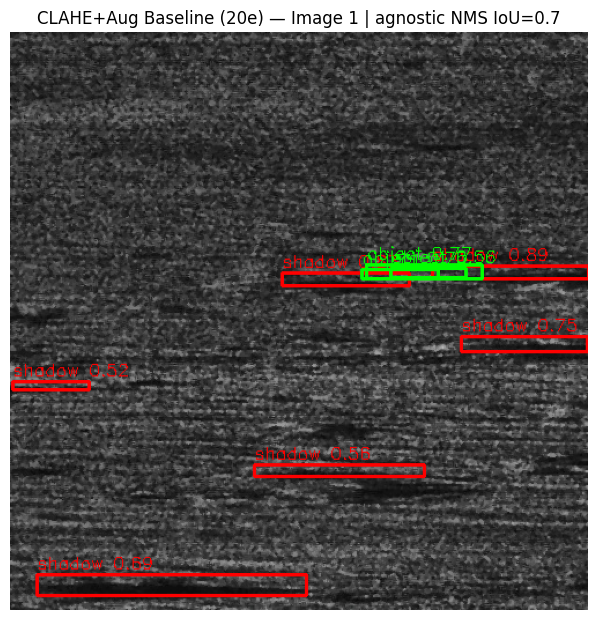

Image 2: shown 8 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


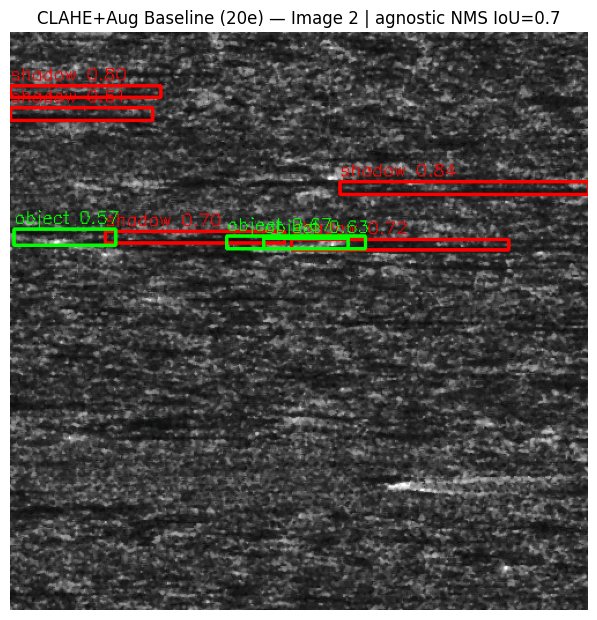

Image 3: shown 3 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


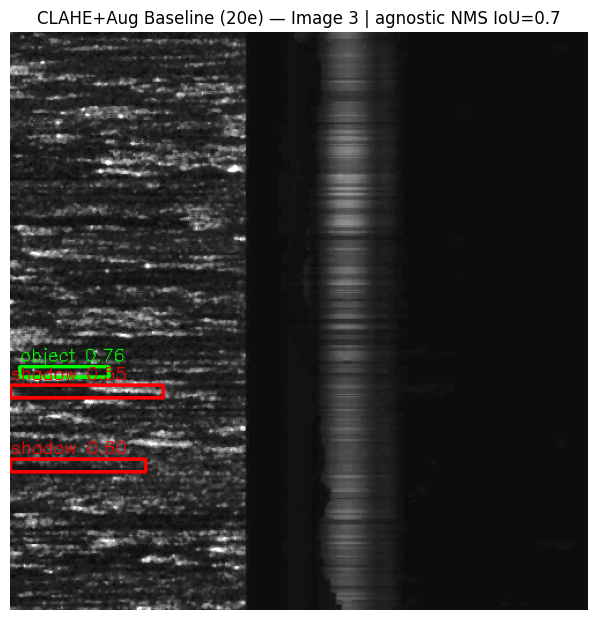

Image 4: shown 10 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


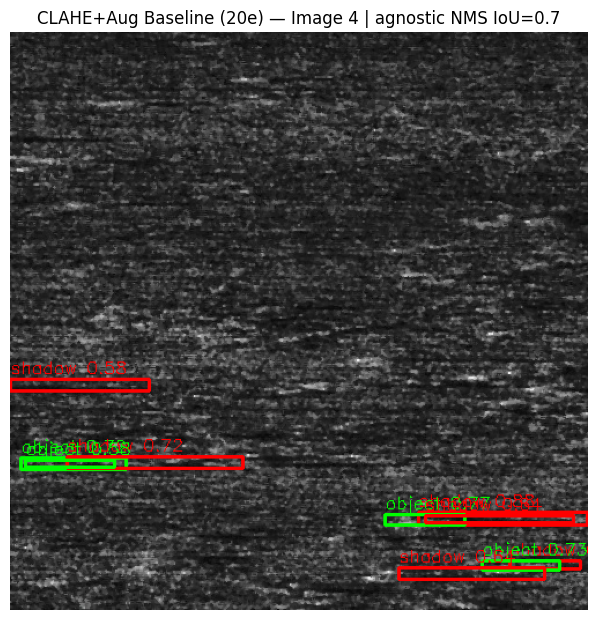

Image 5: shown 2 boxes (≥ 0.50) after agnostic NMS @ IoU=0.70


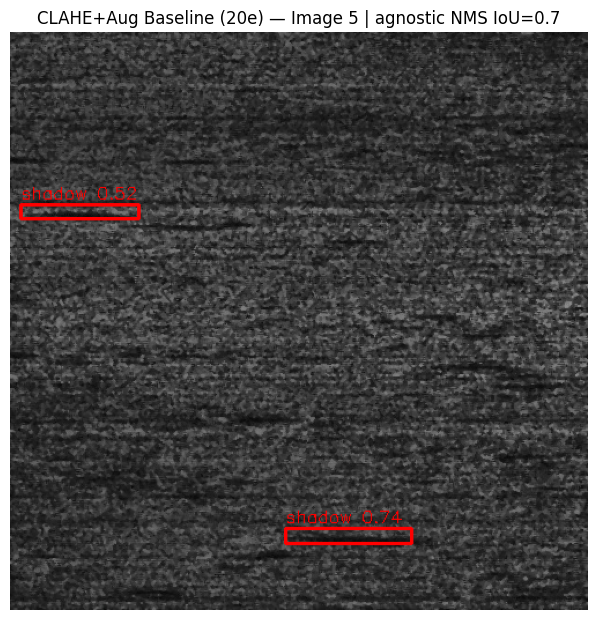

In [6]:
# VISUALIZE PREDICTIONS: Baseline (20 Epochs, CLAHE+Aug Data)

import sys, torch, cv2, numpy as np, matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.ops import nms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    FasterRCNN_ResNet50_FPN_Weights,
)

# Make the dataset class importable
sys.path.append("/content/drive/MyDrive/sonar-object-detection/scripts")
from voc_dataset import VOCDataset

# Config
CONF_THRESH   = 0.5     # show only boxes >= this confidence
IOU_THRESH    = 0.7     # NMS IoU; higher => fewer duplicates in the picture
NMS_MODE      = "agnostic"  # "agnostic" (good for killing dupes) or "classwise"
NUM_IMAGES    = 5
# (CLAHE+Aug split + its checkpoint)
DATASET_ROOT  = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented"
CKPT          = "/content/drive/MyDrive/sonar-object-detection/checkpoints/baseline_frcnn_claheaug_20epoch.pth"

LABEL_NAMES   = {1: "object", 2: "shadow"}
LABEL_COLORS  = {1: (0, 255, 0), 2: (0, 0, 255)}  # green=object, red=shadow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Helper: optional extra NMS
def apply_extra_nms(boxes, scores, labels, iou_thresh=0.5, mode="agnostic"):
    """Extra dedup just for visuals. Model has already done per-class NMS.
    mode="agnostic"  -> suppress across classes (reduces 'double boxes' a lot)
    mode="classwise" -> suppress within each class (more conservative)"""
    if boxes.numel() == 0:
        return torch.empty((0,), dtype=torch.long)

    if mode == "classwise":
        keep_idxs = []
        for cls in torch.unique(labels):
            m = labels == cls
            if m.any():
                kept = nms(boxes[m], scores[m], iou_thresh)
                keep_idxs.append(torch.where(m)[0][kept])
        return torch.cat(keep_idxs) if keep_idxs else torch.empty((0,), dtype=torch.long)

    # default: class-agnostic
    return nms(boxes, scores, iou_thresh)

# Model
# Use DEFAULT so the internal transform (resize + ImageNet mean/std) matches training.
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

# Swap the head to 3 classes: bg(0), object(1), shadow(2).
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)

# Load trained weights and move to eval
state = torch.load(CKPT, map_location=device)
# tolerate either a bare state_dict or {"model": state_dict}
if isinstance(state, dict) and "model" in state:
    state = state["model"]
model.load_state_dict(state)
model.to(device).eval()



# Visualize a few val images
def visualize(model, dataset_root, num_images, conf_thresh, iou_thresh, nms_mode):
    # Note: VOCDataset + ToTensor() -> image in [0,1]; model handles normalization inside.
    ds = VOCDataset(dataset_root, image_set="val", transforms=ToTensor())

    for idx in range(min(num_images, len(ds))):
        img, _ = ds[idx]
        x = img.unsqueeze(0).to(device)

        with torch.no_grad():
            out = model(x)[0]  # Faster R-CNN returns a dict per image

        # Extra NMS purely for aesthetics (see note above)
        keep = apply_extra_nms(out["boxes"], out["scores"], out["labels"],
                               iou_thresh=iou_thresh, mode=nms_mode)
        boxes  = out["boxes"][keep]
        scores = out["scores"][keep]
        labels = out["labels"][keep]

        # Back to an OpenCV image for drawing
        im = cv2.cvtColor(
            (img.mul(255).byte().permute(1, 2, 0).cpu().numpy()),
            cv2.COLOR_RGB2BGR
        )

        kept_count = 0
        for b, l, s in zip(boxes, labels, scores):
            s = float(s)
            if s < conf_thresh:
                continue
            x1, y1, x2, y2 = b.int().tolist()
            color = LABEL_COLORS.get(int(l), (255, 255, 255))
            name  = LABEL_NAMES.get(int(l), "unknown")

            cv2.rectangle(im, (x1, y1), (x2, y2), color, 2)
            cv2.putText(im, f"{name} {s:.2f}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            kept_count += 1

        # Little heads-up in the console (for me, not for the paper)
        print(f"Image {idx+1}: shown {kept_count} boxes (≥ {conf_thresh:.2f}) "
              f"after {nms_mode} NMS @ IoU={iou_thresh:.2f}")

        # Show with matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"CLAHE+Aug Baseline (20e) — Image {idx+1} | {nms_mode} NMS IoU={iou_thresh}")
        plt.tight_layout(pad=0)
        plt.show()


# Shoot
visualize(model, DATASET_ROOT, NUM_IMAGES, CONF_THRESH, IOU_THRESH, NMS_MODE)